# First attempts at supervised classification for flares

I am using only the data that were in visual_data.fits, which had a cutoff at CON_NSIGMA > 5. Flares are defined as having the FLARE variable = 'Y' (FLARE='-' were treated as no flare). Only the 499 second observations are included. I exported the data csv files and cross-matched on extras-ID.

I split the data into train-test randomly. I run a two-class supervised classification. I evaluate the performance using the f1 score, the accuracy, and by looking at the confusion matrix directly.

I compare the performance of two models: [XGBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (gradient boosted trees) and [FIGS](https://bair.berkeley.edu/blog/2022/06/30/figs). The former model is not interpretable, the latter is.

Finally, I use some explainability techniques on the uninterpretable XGBoost model to explain its decisions a posteriori. 

In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
from imodels import FIGSClassifier, FIGSRegressor, get_clean_dataset, FIGSClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier as xgb
import seaborn as sns

In [2]:
#Code I formerly used to read the fits files and write the csv, unnecessary now

#with fits.open("2012-2020_visual.fit") as visual:
#    native_visual_data = visual[1].data
#    visual_data = pd.DataFrame.from_records(native_visual_data)

#with fits.open("apex_2000-2020_complete.fit") as complete:
#    native_complete_data = complete[1].data
#    complete_data = pd.DataFrame.from_records(native_complete_data)

#visual_data.to_csv("visual_data.csv")
#complete_data.to_csv("complete_data.csv")

### Reading in the data

In [3]:
visual_data = pd.read_csv("visual_data.csv")

In [4]:
complete_data = pd.read_csv("complete_data_499.csv")

In [5]:
cdf = pd.read_csv("cdf_499.csv")

In [16]:
cdf['EXTRAS_ID'] = np.array([str(s)[2:-1] for s in cdf['EXTRAS_ID']])

In [17]:
cdf.head()

Unnamed: 0         OBS_ID  SRC_NUM  BIN_SIZE     F_VAR  F_VAR_ERR  \
0           2  b'0000110101'        1       499  0.692592   0.165601   
1           6  b'0000110101'        2       499  0.997198   0.264032   
2          10  b'0000110101'        3       499  0.788664   0.615132   
3          14  b'0000110101'        4       499  1.926109   1.752167   
4          18  b'0000110101'        5       499  1.662160   0.516661   

            AVE       AVE_ERR         STDEV          SKEW  ...      FLUX_P40  \
0  1.350140e-13  1.527083e-14  1.891364e-13 -1.577253e-39  ...  1.025936e-13   
1  3.009117e-14  8.882952e-15  9.760700e-14 -2.143861e-40  ...  2.122912e-14   
2  2.041009e-14  6.064366e-15  6.238247e-14  1.746324e-40  ...  4.900570e-15   
3 -9.831734e-15  6.184388e-15  5.308298e-14 -9.130072e-41  ... -2.952255e-14   
4 -4.676036e-15  4.837585e-15  4.365292e-14  1.337472e-40  ... -9.115572e-15   

       FLUX_P50      FLUX_P60    FLUX_P67.5      FLUX_P75    FLUX_P82.5  \
0  1.669971e-13  2.281533e-13  2.736146e-13  3.228643e-13  3.818557e-13   
1  5.609994e-14  9.367392e-14  1.234087e-13  1.561170e-13  1.963942e-13   
2  3.078012e-14  5.932018e-14  8.181361e-14  1.069676e-13  1.374425e-13   
3 -9.982597e-15  1.049904e-14  2.792021e-14  4.863727e-14  7.406276e-14   
4  5.942725e-15  2.325977e-14  3.944744e-14  6.052905e-14  9.064565e-14   

       FLUX_P90      FLUX_P95      FLUX_P99           EXTRAS_ID  
0  4.668250e-13  5.680305e-13  7.785595e-13  0000110101_001_499  
1  2.550528e-13  3.274976e-13  5.067174e-13  0000110101_002_499  
2  1.812201e-13  2.337048e-13  3.657630e-13  0000110101_003_499  
3  1.103176e-13  1.536351e-13  2.680498e-13  0000110101_004_499  
4  1.358205e-13  1.877717e-13  3.699771e-13  0000110101_005_499  

[5 rows x 55 columns]

### Cross matching on EXTRAS_ID and prepping

This was a bit of a pain using the whole complete_data because it would run out of memory on my laptop, but it works now by restricting to complete_data_499 only.

In [18]:
data_visual_complete = pd.merge(visual_data, complete_data, how='inner', on = 'EXTRAS_ID')
data = pd.merge(data_visual_complete, cdf, how='inner', on = 'EXTRAS_ID')

Verify that the data is already cut off to 5 sigma for the constant fit

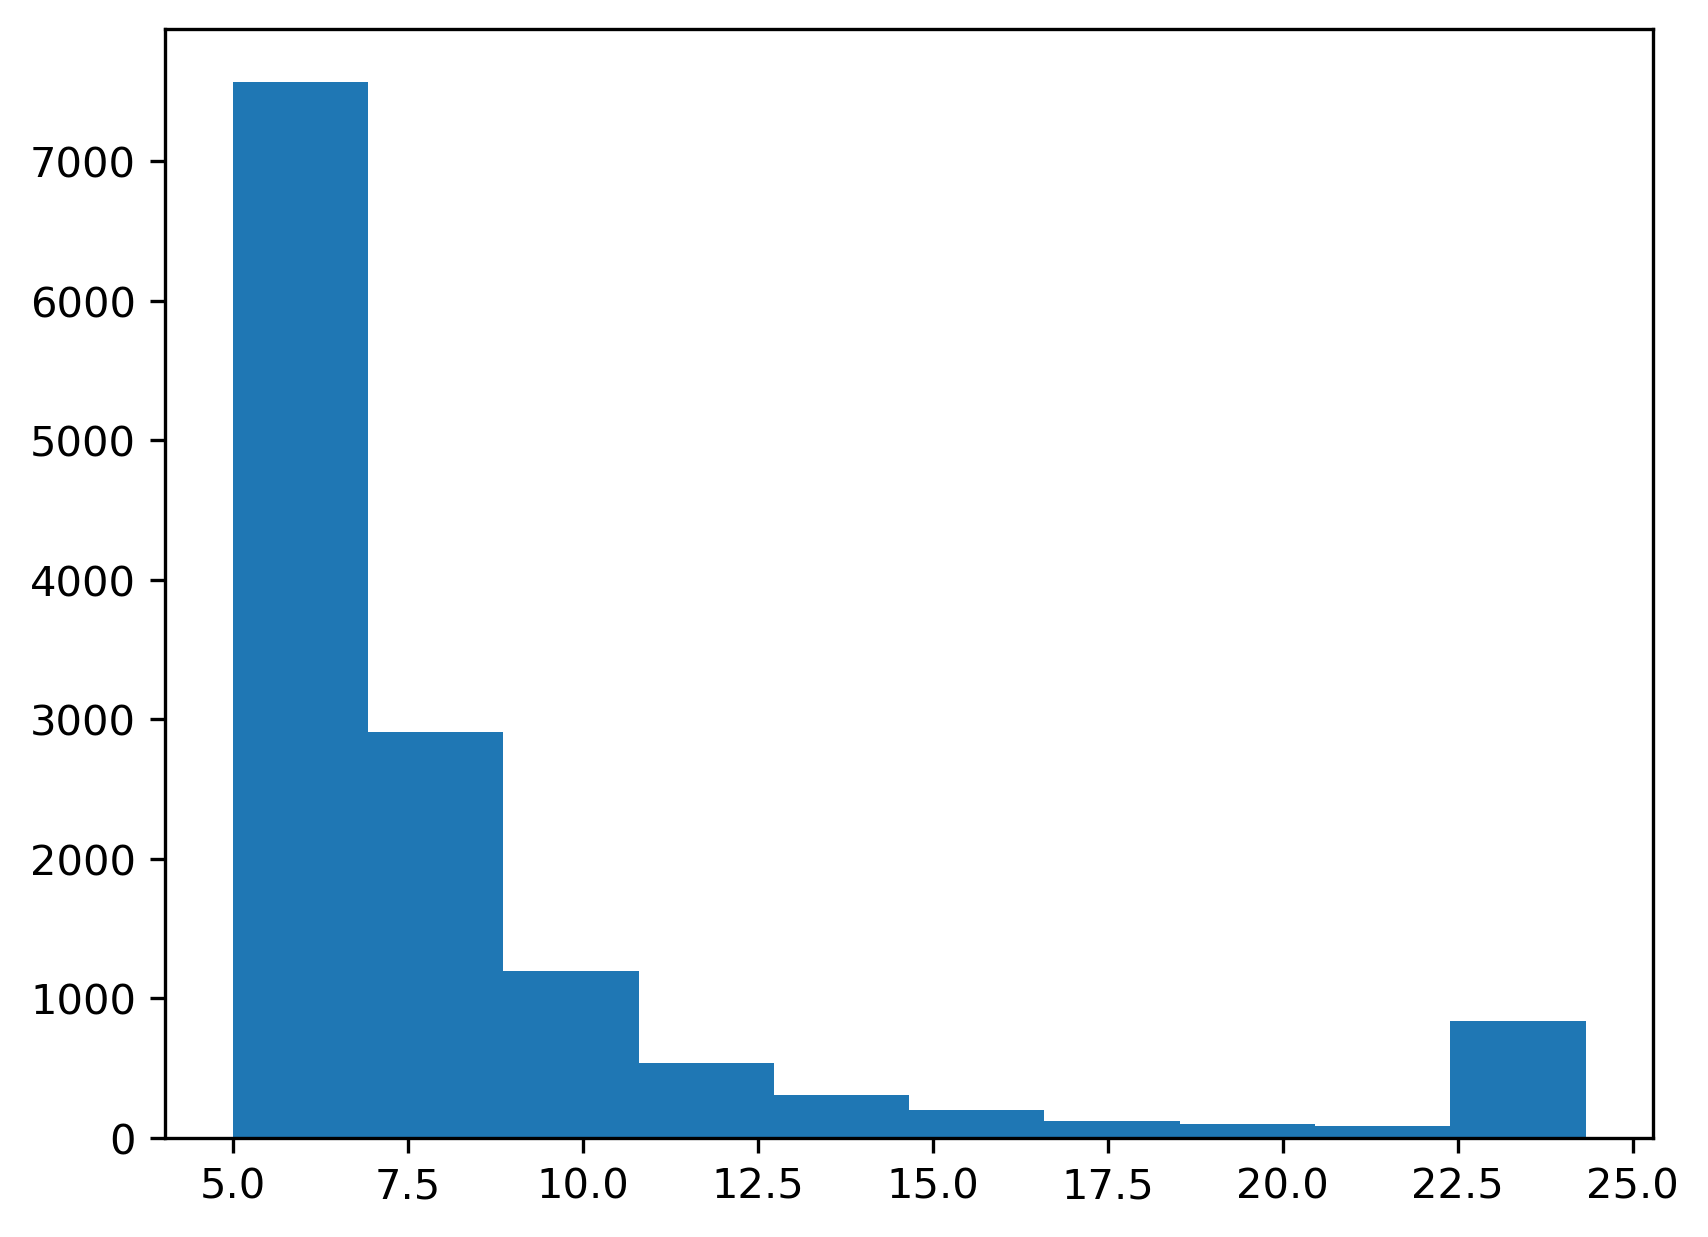

In [20]:
plt.hist(data['CON_NSIGMA'])
plt.show()

It is, though something fishy is going on on the right hand side at very high sigma. What is that?

Let us see the names of all the columns in the combined dataframe

In [25]:
retain = np.zeros(len(data.columns), dtype=bool)
for i, c in zip(range(len(data.columns)), data.columns):
    if (i > 23) and (i < 145):
        if not (c.endswith('TS') or c.endswith('NHP') or c.startswith('F_NSIGMA')):
            retain[i] = True
    print(i, c)

retain[179:183] = True
retain[185] = True 
retain[143] = False
print(retain)

0 Unnamed: 0_x
1 OBS_ID_x
2 SRC_NUM_x
3 DIPECLPER
4 MULTIDEP
5 FLARE
6 MULTIFL
7 FIT
8 GOOD_FIT
9 EXTRAS_ID
10 Unnamed: 0_y
11 3XMM
12 4XMM
13 PPS
14 OBS_ID_y
15 SRC_NUM_y
16 BIN_SIZE_x
17 PRED_CTS_INREG
18 PN_RAWCTS
19 M1_RAWCTS
20 M2_RAWCTS
21 TSTART_LC
22 TSTOP_LC
23 N_BINS
24 AVERAGE
25 AVERAGE_ERR
26 ST_DEV
27 MEDIAN_x
28 MED_ABS_DEV_x
29 CON_TS
30 CON_NHP
31 CON_NSIGMA
32 CON_CON
33 CON_CON_ERR
34 LIN_TS
35 LIN_NHP
36 LIN_NSIGMA
37 LIN_CON
38 LIN_CON_ERR
39 LIN_LIN
40 LIN_LIN_ERR
41 QU_TS
42 QU_NHP
43 QU_NSIGMA
44 QU_CON
45 QU_CON_ERR
46 QU_LIN
47 QU_LIN_ERR
48 QU_QU
49 QU_QU_ERR
50 EXP_TS
51 EXP_NHP
52 EXP_NSIGMA
53 EXP_CON
54 EXP_CON_ERR
55 EXP_NOR
56 EXP_NOR_ERR
57 EXP_EXP
58 EXP_EXP_ERR
59 DIP1_TS
60 DIP1_NHP
61 DIP1_NSIGMA
62 DIP1_TMIN
63 DIP1_TMIN_ERR
64 DIP1_DT
65 DIP1_DT_ERR
66 DIP1_FLMIN
67 DIP1_FLMIN_ERR
68 DIP1_FLMAX
69 DIP1_FLMAX_ERR
70 DIP_TS
71 DIP_NHP
72 DIP_NSIGMA
73 DIP_TMIN
74 DIP_TMIN_ERR
75 DIP_DT
76 DIP_DT_ERR
77 DIP_FLMIN
78 DIP_FLMIN_ERR
79 DIP_FLMAX
80 DIP

Preparing the final dataset for train-test splitting. I am turning 'FLARE' into a binary variable and selecting only certain columns (from 24 to 144, see to what this corresponds in terms of variable names by looking above). I then split the dataset into train-test. The split is stratified given how unbalanced the data set is.

In [26]:
y = data.copy()['FLARE']
y[y == '-'] = 'N'
y = (y=='Y')
X = data.copy().iloc[:,retain]

feat_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)
feat_names

Index(['AVERAGE', 'AVERAGE_ERR', 'ST_DEV', 'MEDIAN_x', 'MED_ABS_DEV_x',
       'CON_NSIGMA', 'CON_CON', 'CON_CON_ERR', 'LIN_NSIGMA', 'LIN_CON',
       'LIN_CON_ERR', 'LIN_LIN', 'LIN_LIN_ERR', 'QU_NSIGMA', 'QU_CON',
       'QU_CON_ERR', 'QU_LIN', 'QU_LIN_ERR', 'QU_QU', 'QU_QU_ERR',
       'EXP_NSIGMA', 'EXP_CON', 'EXP_CON_ERR', 'EXP_NOR', 'EXP_NOR_ERR',
       'EXP_EXP', 'EXP_EXP_ERR', 'DIP1_NSIGMA', 'DIP1_TMIN', 'DIP1_TMIN_ERR',
       'DIP1_DT', 'DIP1_DT_ERR', 'DIP1_FLMIN', 'DIP1_FLMIN_ERR', 'DIP1_FLMAX',
       'DIP1_FLMAX_ERR', 'DIP_NSIGMA', 'DIP_TMIN', 'DIP_TMIN_ERR', 'DIP_DT',
       'DIP_DT_ERR', 'DIP_FLMIN', 'DIP_FLMIN_ERR', 'DIP_FLMAX',
       'DIP_FLMAX_ERR', 'DIP_PER', 'DIP_PER_ERR', 'EC1_NSIGMA', 'EC1_TIN',
       'EC1_TIN_ERR', 'EC1_TFIN', 'EC1_TFIN_ERR', 'EC1_FLMIN', 'EC1_FLMIN_ERR',
       'EC1_FLMAX', 'EC1_FLMAX_ERR', 'EC_NSIGMA', 'EC_T1', 'EC_T1_ERR',
       'EC_T2', 'EC_T2_ERR', 'EC_FL1', 'EC_FL1_ERR', 'EC_FL2', 'EC_FL2_ERR',
       'EC_PER', 'EC_PER_ERR', 'FL_NSIGMA',

### Training XGBoost, a black box model

Now let us fit an XGBoost model to the training data and evaluate its predictions on the test data. Note that I am not optimizing the model's hyperparameters.

In [27]:
model_xgb = xgb()  
model_xgb.fit(X_train, y_train)  
preds_xgb = model_xgb.predict(X_test)

In [28]:
accuracy_xgb = accuracy_score(y_test, preds_xgb)
accuracy_xgb

0.964994586791772

The accuracy score is deceivingly high. The dataset is very unbalanced, so predicting always no flare would yield an accuracy of:

In [29]:
sum(1-y_test)/len(y_test)

0.9231324431613136

Clearly we need a better metric for evaluating the classifier. Here is the raw confusion matrix:

In [30]:
confusion_matrix(y_test, preds_xgb)

array([[2524,   34],
       [  63,  150]])

The precision score (aka purity in astro catalogs) measures what fraction of actual flares was found among the sources tagged as flares. It is pretty decent:

In [31]:
precision_xgb = precision_score(y_test, preds_xgb)
precision_xgb

0.8152173913043478

On the other hand the recall score (completeness for astronomers I guess) is not so good:

In [32]:
recall_xgb = recall_score(y_test, preds_xgb)
recall_xgb

0.704225352112676

The recall score is the fraction of actual flares we correctly tag as flares. We miss one in four.

The F1 score summarizes both recall and precision by taking their harmonic mean. Here it is:

In [33]:
f1_xgb = f1_score(y_test, preds_xgb)
f1_xgb

0.7556675062972291

### Training FIGS, an interpretable model

Let us see how this compares to an interpretable model, FIGS. This is an ensemble of decision trees, like XGBoost, but the trees are just a few and they have very few branches. They are trained differently from XGBoost, of course. The result is capable of capturing the additive structure of a dataset (if any) while staying relatively interpretable.
Below is a simple example to understand how the fitted model looks like.

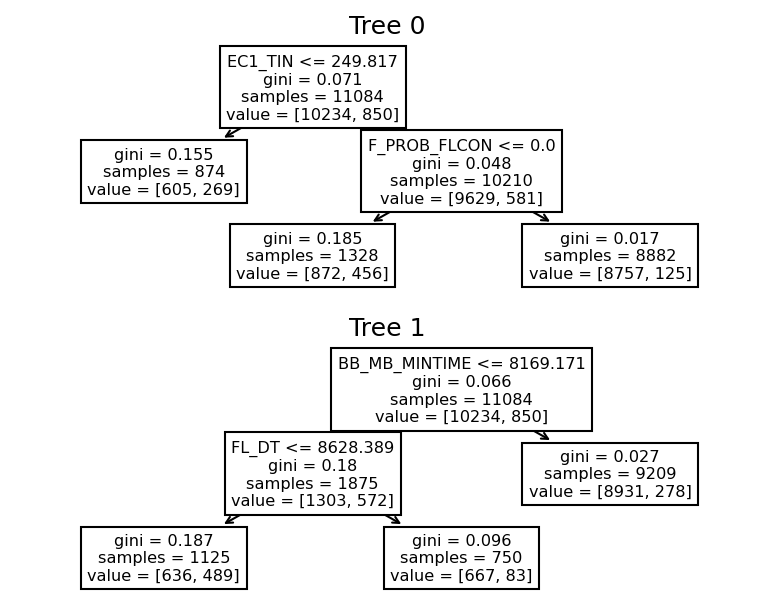

In [34]:
model = FIGSClassifier(max_rules=4, max_trees=3, max_features='sqrt', random_state=888) #despite giving it the seed here it is not deterministic still
model.fit(X_train, y_train)   
preds = model.predict(X_test) 
preds_proba = model.predict_proba(X_test)

model.plot(feature_names=feat_names, label='all', impurity=True)

In [35]:
confusion_matrix(y_test, preds)

array([[2505,   53],
       [ 108,  105]])

Accuracy stays good but for the wrong reasons (see discussion above):

In [36]:
accuracy_score(y_test, preds)

0.9418982316853122

the F1 score becomes abysmal:

In [37]:
f1_score(y_test, preds)

0.5660377358490566

Precision degraded a bit

In [38]:
precision_score(y_test, preds)

0.6645569620253164

Even more so recall:

In [39]:
recall_score(y_test, preds)

0.49295774647887325

### Optimizing FIGS in cross-validation

Maybe the interpretable model will do better if optimized. We do this by training it with different hyperparameters (the number of splits in total (number of rules) and the number of total trees). I optimize for the F1 score in cross validation.

In [40]:
model_FIGS_CV = FIGSClassifierCV(n_rules_list = [2,3,4,5,6,7,8,9,10,11,12], n_trees_list = [12,12,12,12,12,12,12,12,12,12,12], scoring='f1')  # initialize a model
model_FIGS_CV.fit(X_train, y_train)   
preds_FIGS_CV = model_FIGS_CV.predict(X_test)
preds_proba_FIGS_CV = model_FIGS_CV.predict_proba(X_test)

Here are the performance metrics on unseen test data:

In [41]:
accuracy = accuracy_score(y_test, preds_FIGS_CV)
accuracy

0.9588596174666185

In [42]:
f1 = f1_score(y_test, preds_FIGS_CV)
f1

0.7000000000000001

In [43]:
precision = precision_score(y_test, preds_FIGS_CV)
precision

0.7964071856287425

In [44]:
recall = recall_score(y_test, preds_FIGS_CV)
recall

0.6244131455399061

Compare to the results with (unoptimized) XGBoost:

In [45]:
print(accuracy, precision, recall, f1)
print(accuracy_xgb, precision_xgb, recall_xgb, f1_xgb)

0.9588596174666185 0.7964071856287425 0.6244131455399061 0.7000000000000001
0.964994586791772 0.8152173913043478 0.704225352112676 0.7556675062972291


Not that bad after all. Here is how the model looks like:

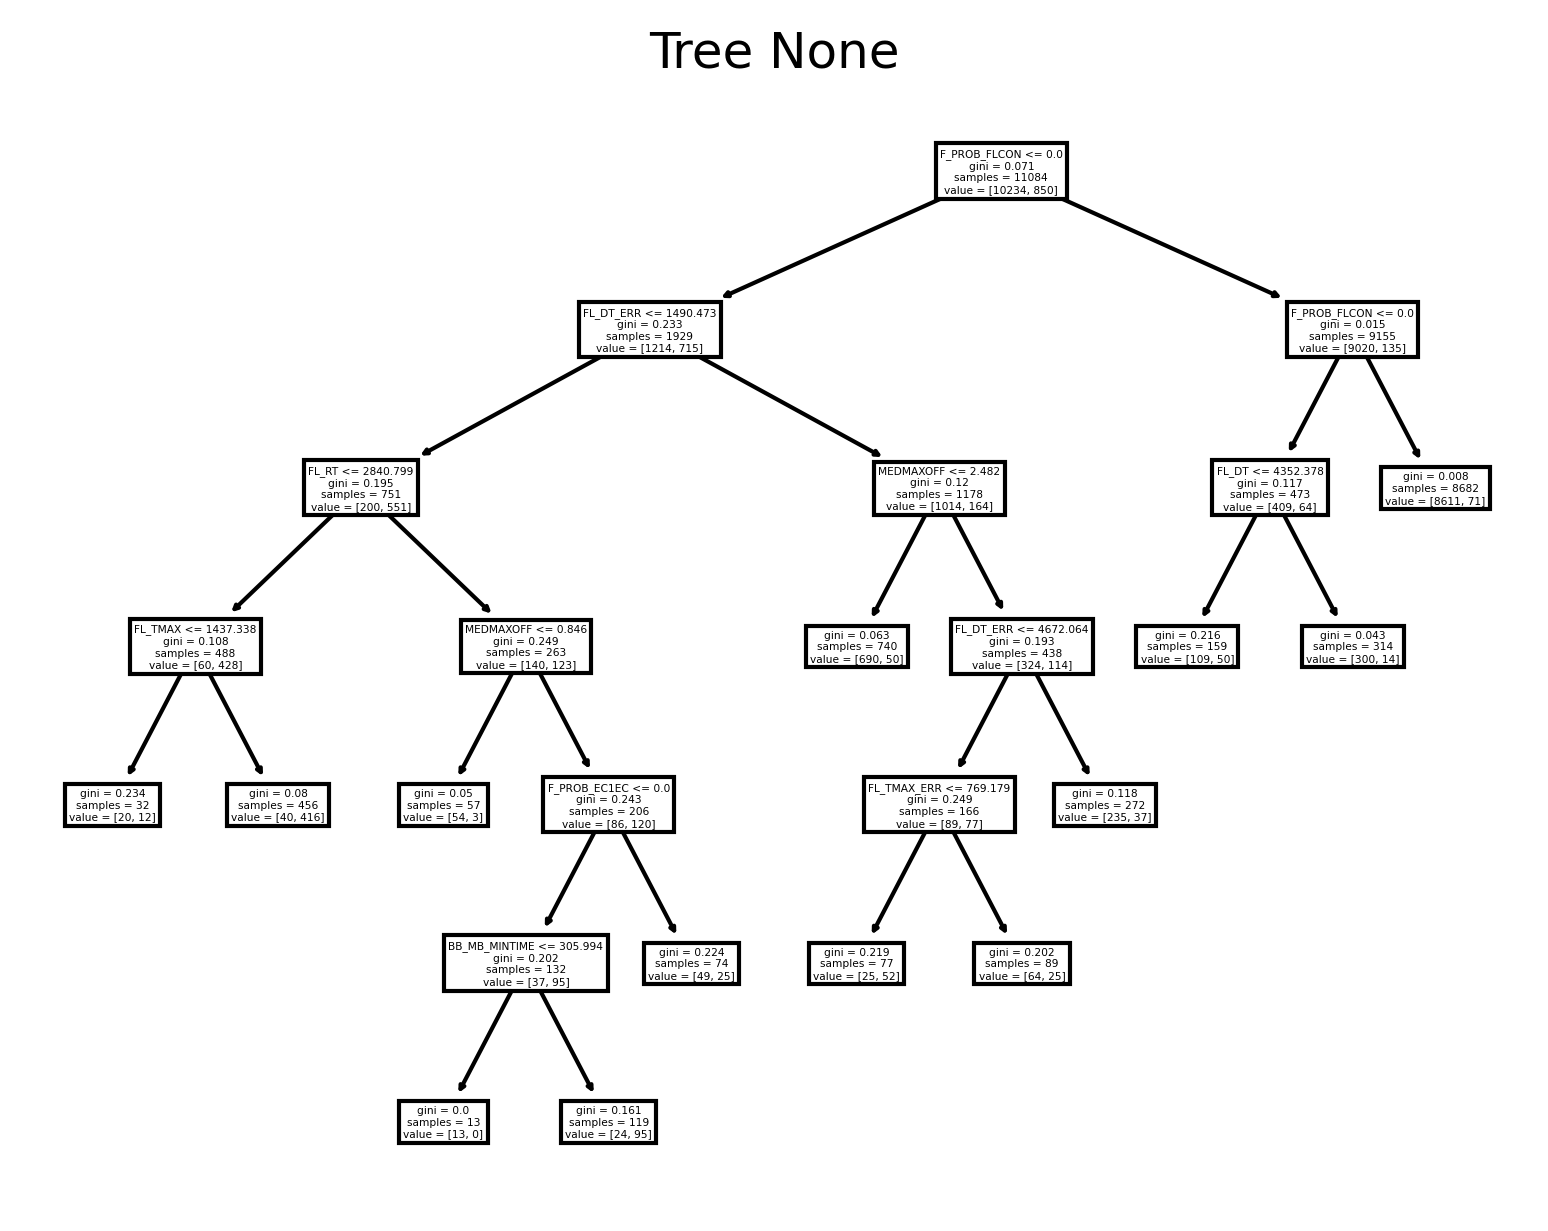

In [46]:
model_FIGS_CV.figs
model_FIGS_CV.figs.plot(feature_names=feat_names, label='all', impurity=True, dpi=300)

The tree uses the variables F_PROB_FLCON and FL_DT_ERR in the first splits. How does the dataset look like in those variables?

/opt/anaconda3/envs/extras/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


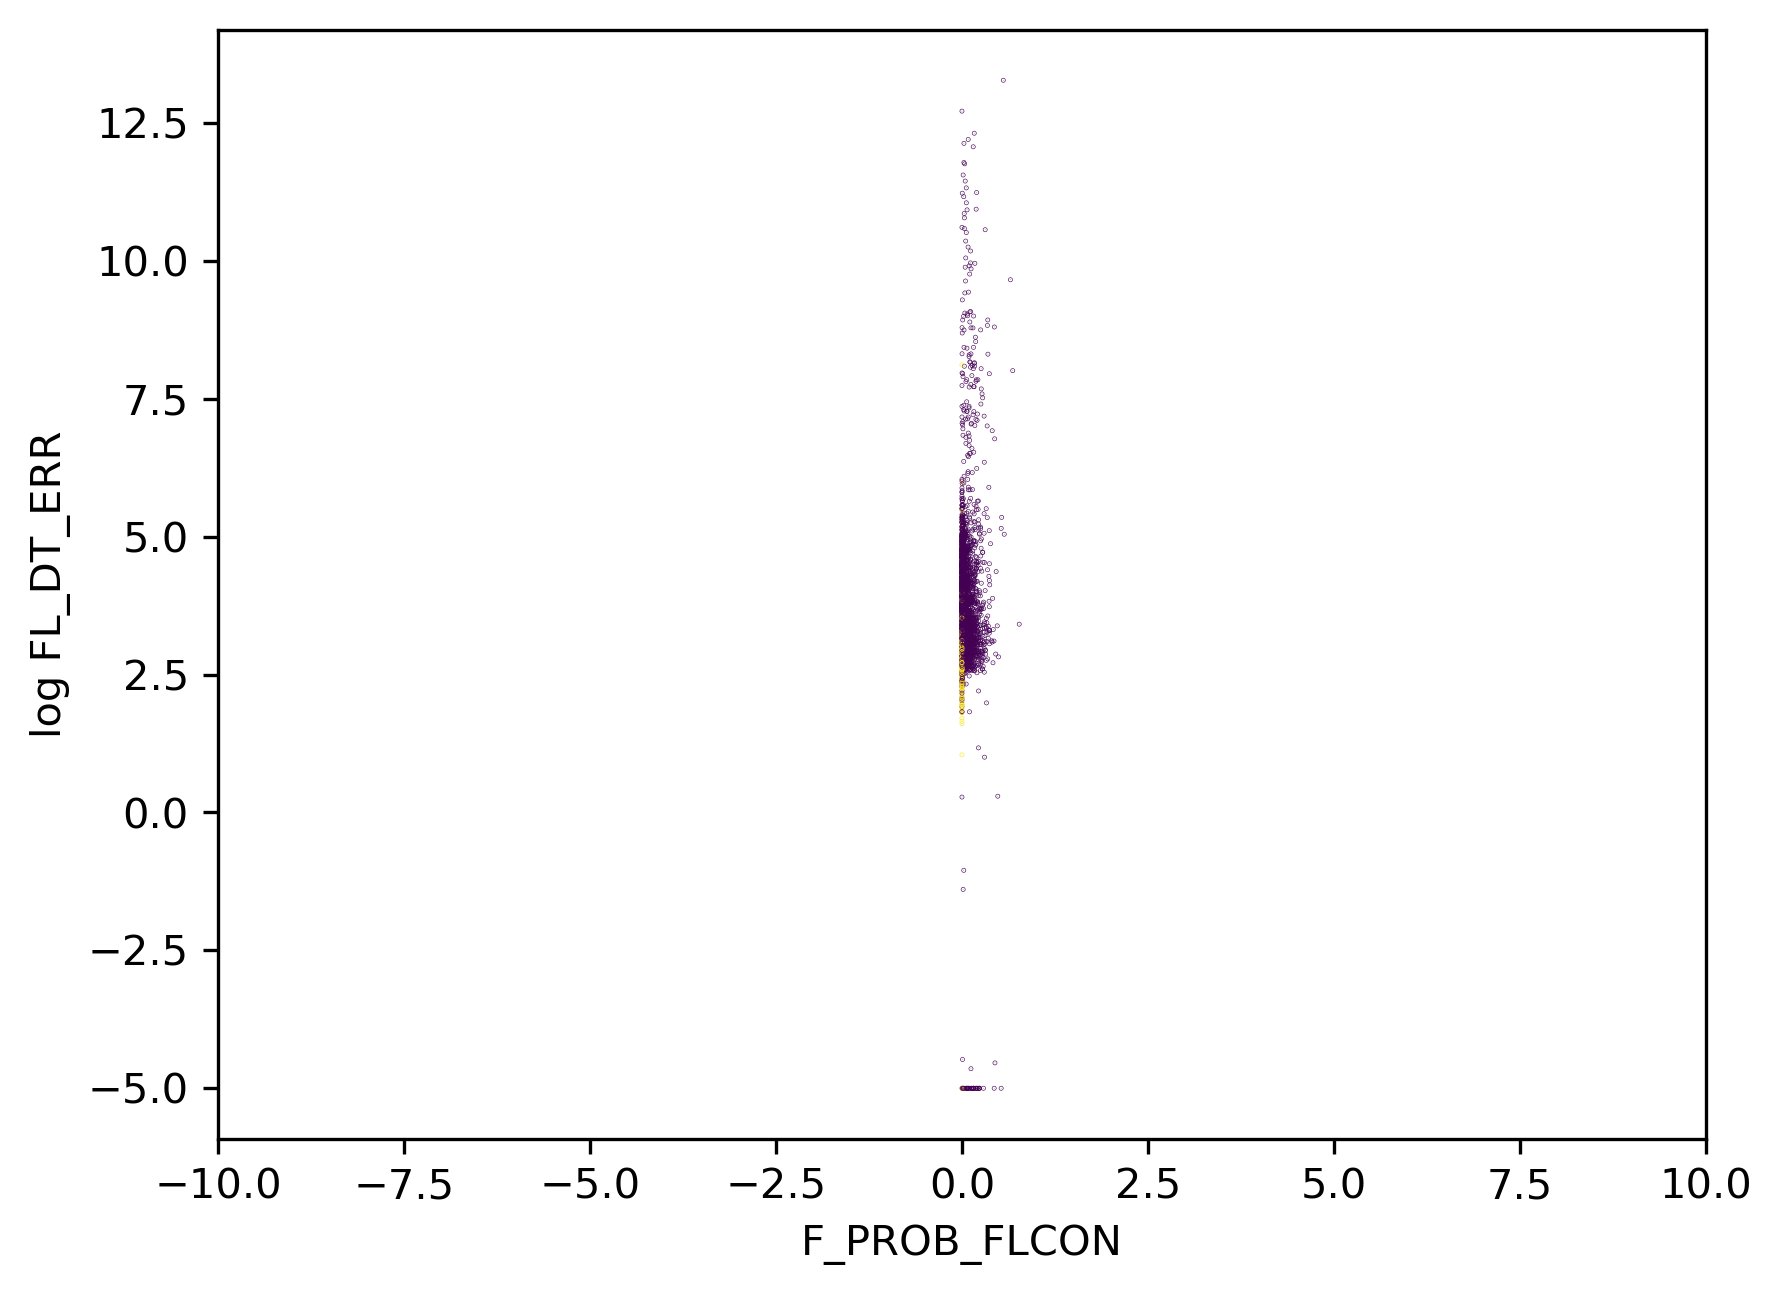

In [47]:
plt.scatter(X_test['F_PROB_FLCON'], np.log10(0.00001+X_test['FL_DT_ERR']), c=y_test, s=0.02)
plt.xlim([-10,10])
plt.xlabel("F_PROB_FLCON")
plt.ylabel('log FL_DT_ERR')
plt.show()

Indeed these two variables alone are already doing a good job of selecting the flares.

### Post-hoc explainability on XGBoost

In [48]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_xgb, X_test, y_test, n_repeats=30, random_state=888)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 3 * r.importances_std[i] > 0: #stuff that is useful at the three-sigma level
         print(f"{X.columns[i]:<8} "
               f"{r.importances_mean[i]:.3f} "
               f" +/- {r.importances_std[i]:.3f}")

F_PROB_FLCON 0.062  +/- 0.003
FL_DT_ERR 0.024  +/- 0.003
FL_NSIGMA 0.007  +/- 0.002
MEDMAXOFF 0.005  +/- 0.002
FL_RT_ERR 0.003  +/- 0.001
FL_TMAX_ERR 0.002  +/- 0.000
F_PROB_DIPCON 0.001  +/- 0.000


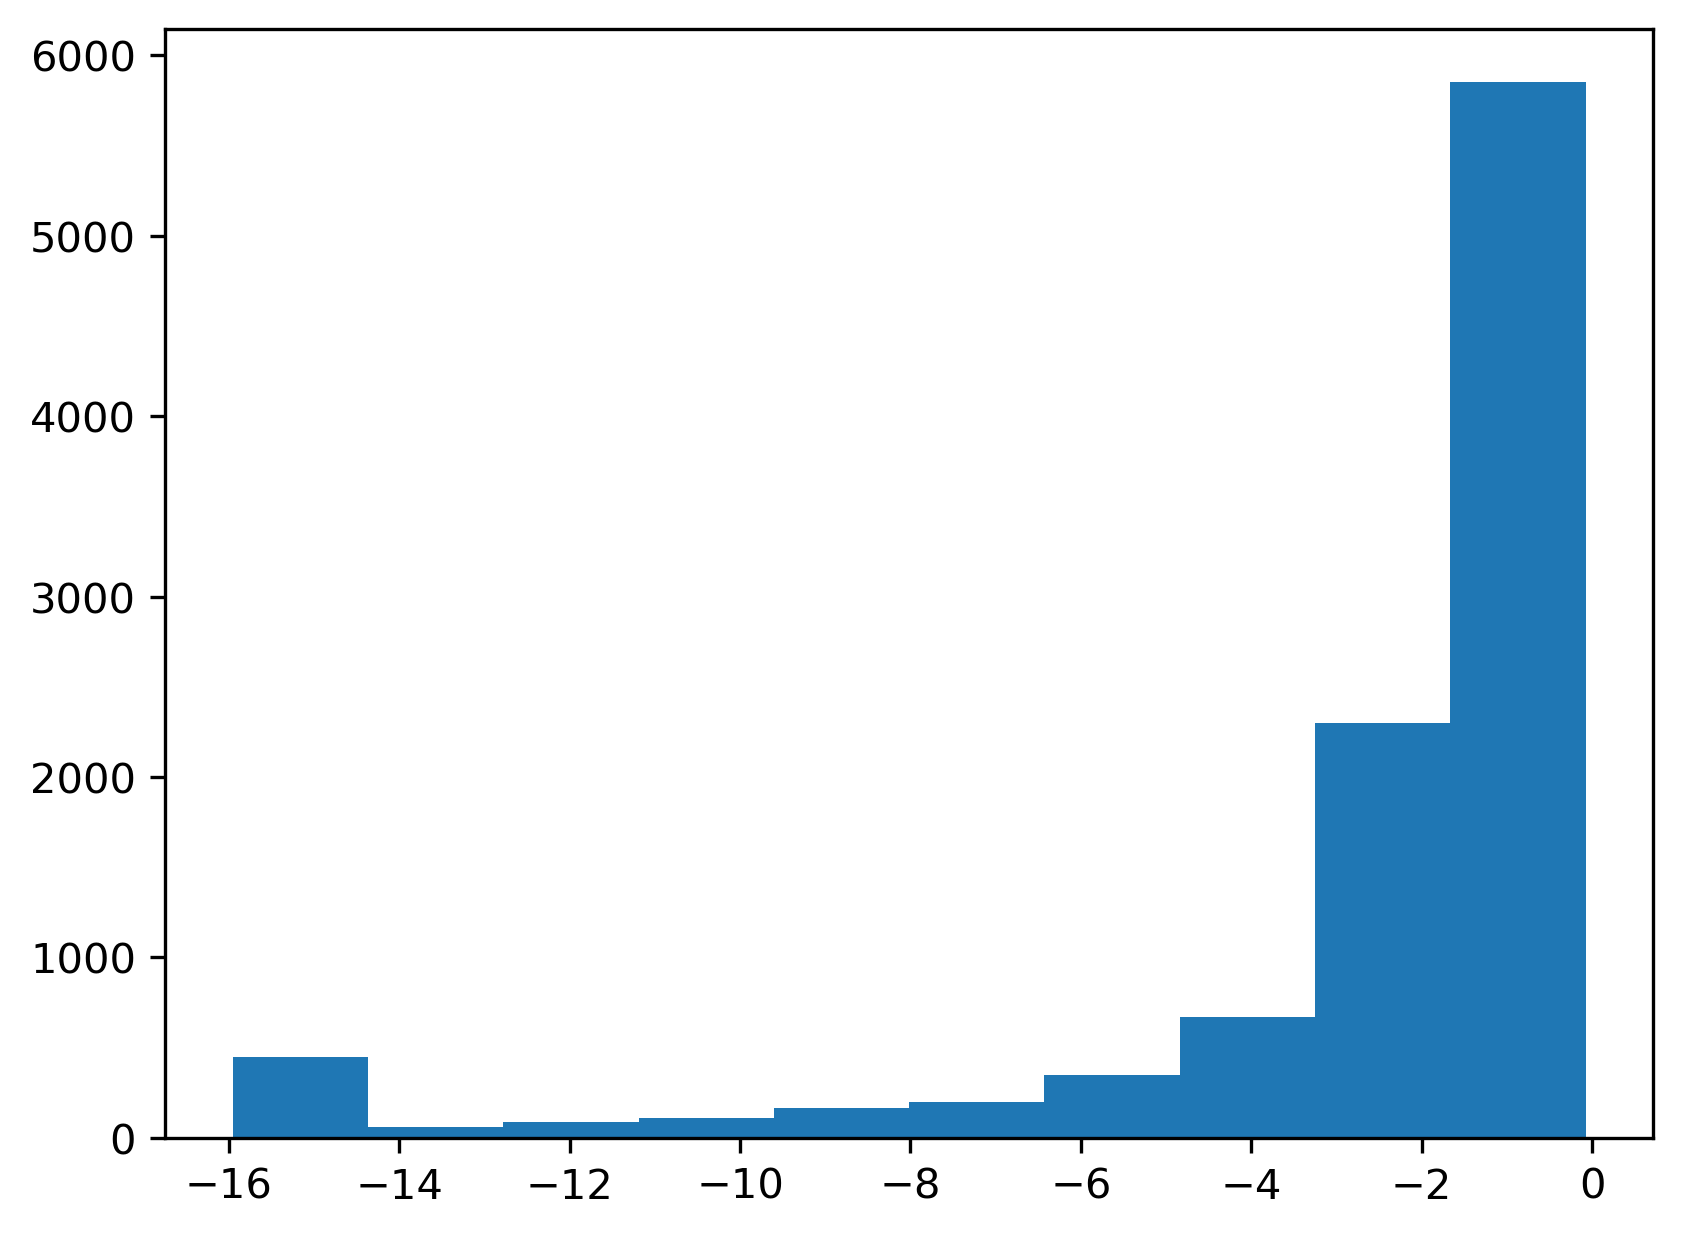

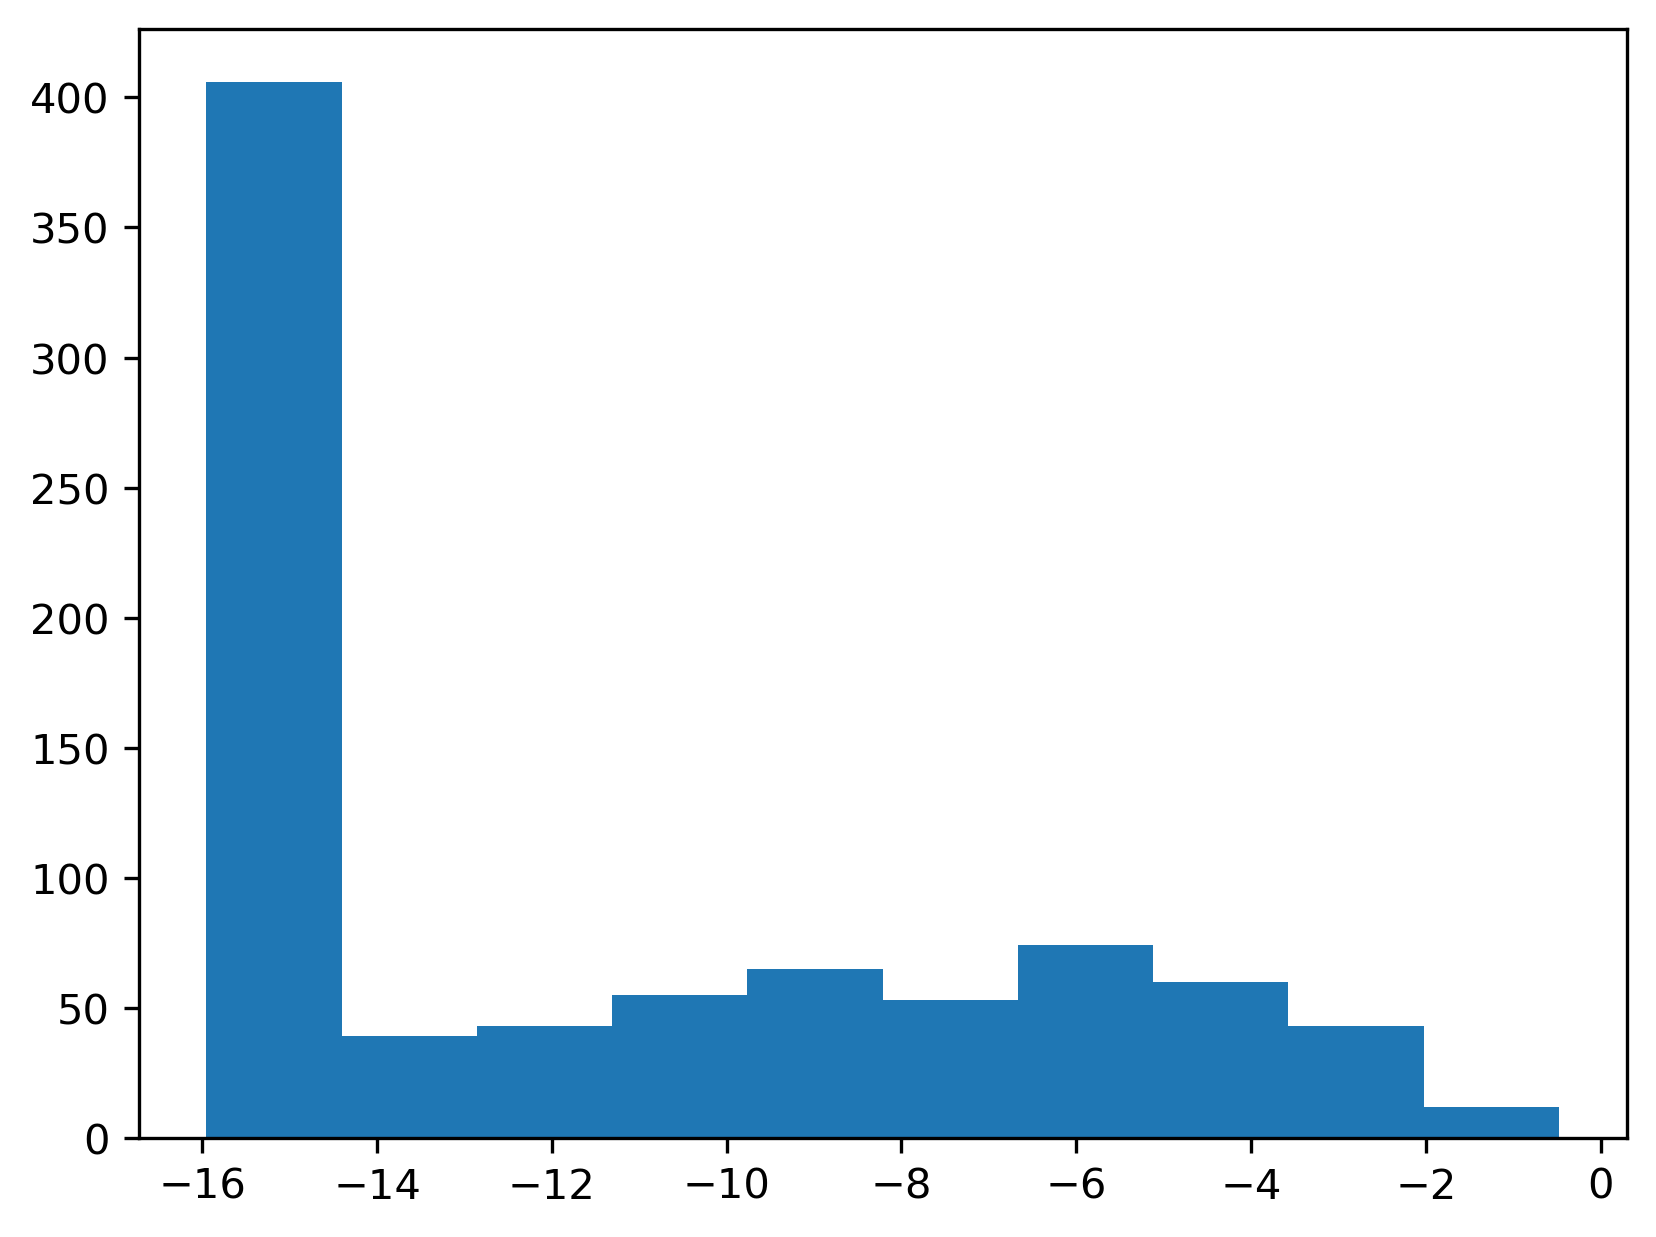

105 2457 108 100
0.5192307692307693
0.5070422535211268


In [82]:
plt.hist(np.log10(X_train['F_PROB_FLCON'][~y_train]))
plt.show()
plt.hist(np.log10(X_train['F_PROB_FLCON'][y_train]))
plt.show()

fn = (np.log10(X_test['F_PROB_FLCON'][y_test]) > -14).sum()
tn = (np.log10(X_test['F_PROB_FLCON'][~y_test]) > -14).sum()
tp = (np.log10(X_test['F_PROB_FLCON'][y_test]) <= -14).sum()
fp = (np.log10(X_test['F_PROB_FLCON'][~y_test]) <= -14).sum()

print(fn, tn, tp, fp)

precision_simple_cutoff = tp/(fp+tp)
recall_simple_cutoff = tp/(fn+tp)
f1_simple_cutoff = 2.0/((1/precision_simple_cutoff) + (1/recall_simple_cutoff))
accuracy_simple_cutoff = (tp+tn)/(fp+fn+tp+tn)

print(accuracy_xgb, precision_xgb, recall_xgb, f1_xgb)
print(accuracy_simple_cutoff, precision_simple_cutoff, recall_simple_cutoff, f1_simple_cutoff)

In fact F_PROB_FLCON and FL_DT_ERR are important variables for XGBoost too. What about FL_NSIGMA?

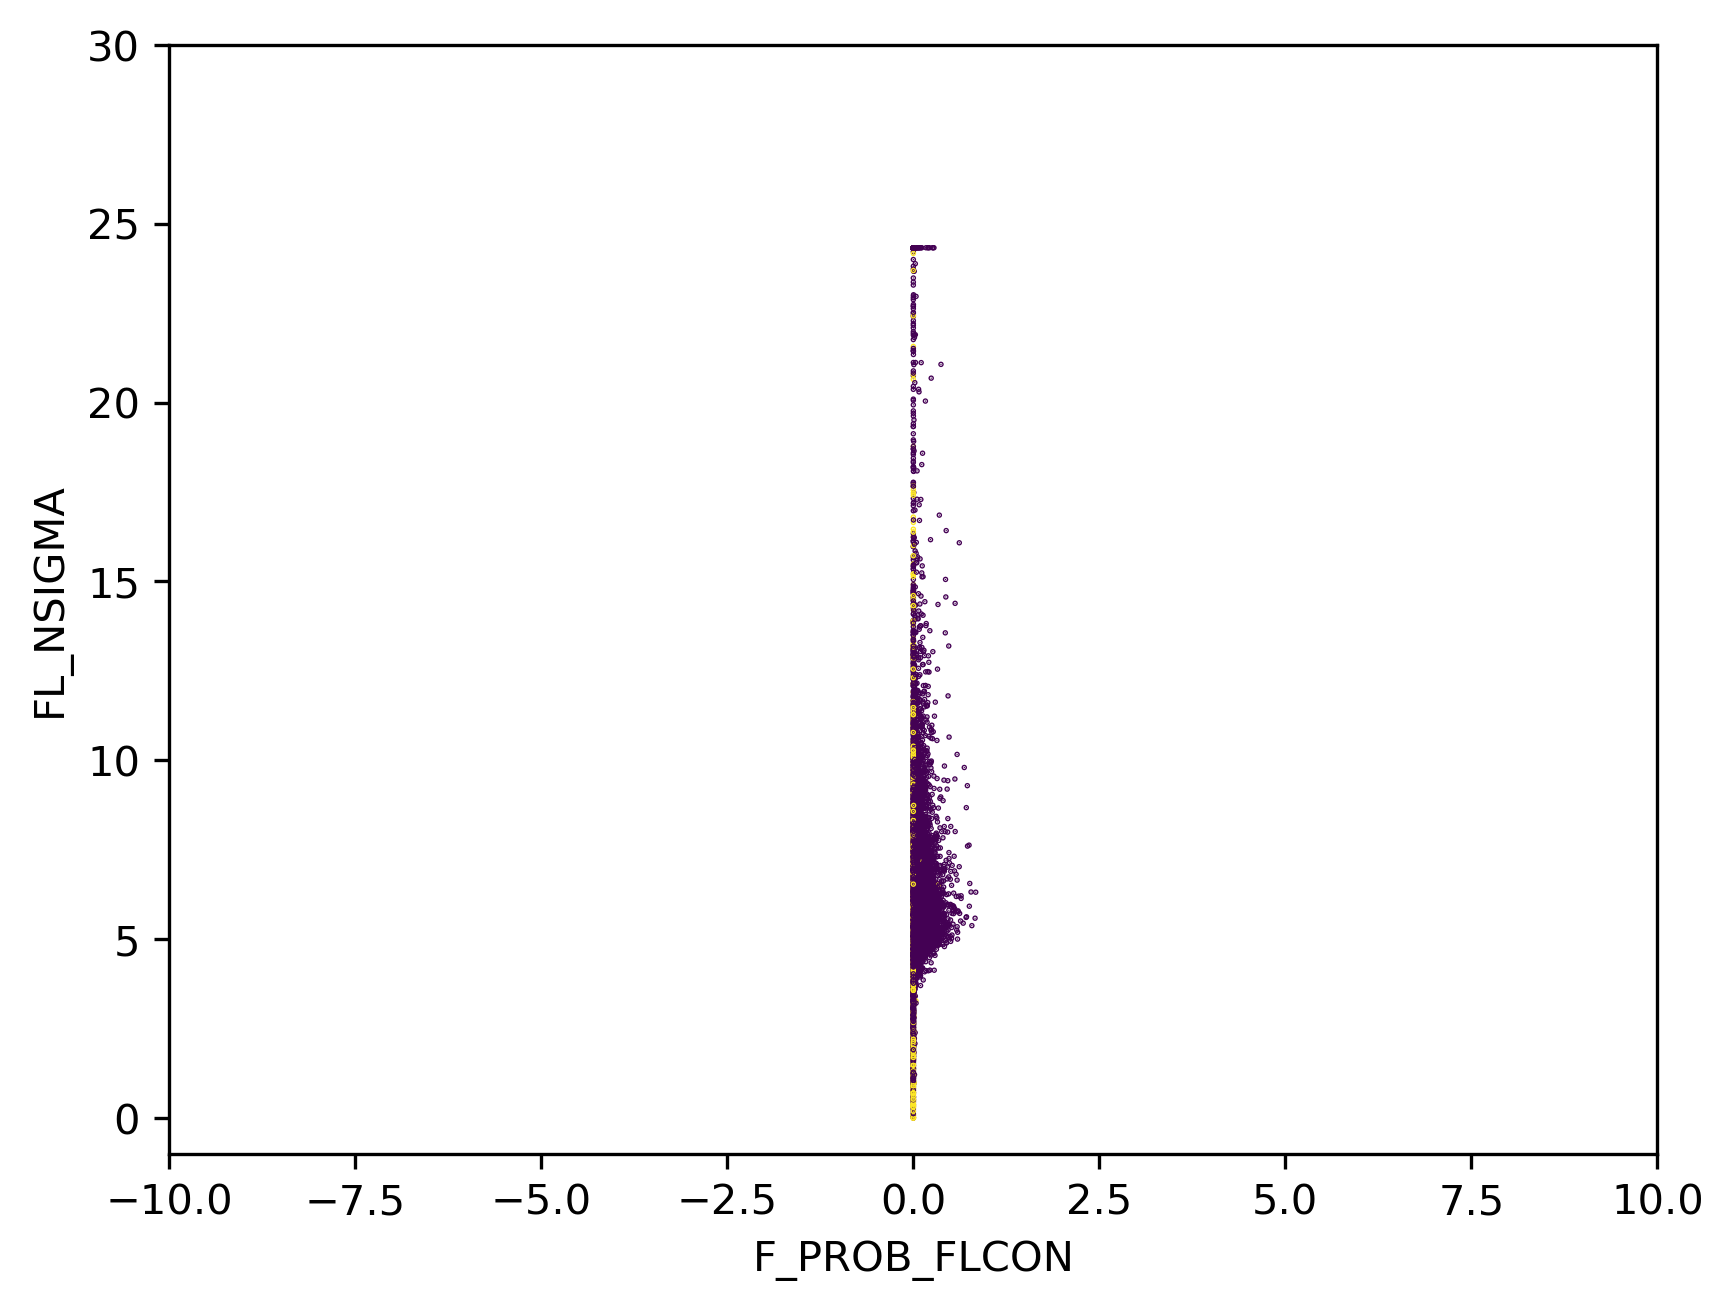

In [58]:
plt.scatter(X_train['F_PROB_FLCON'], X_train['FL_NSIGMA'], c=y_train, s=0.1)
plt.xlim([-10,10])
plt.ylim([-1,30])
plt.xlabel("F_PROB_FLCON")
plt.ylabel('FL_NSIGMA')
plt.show()

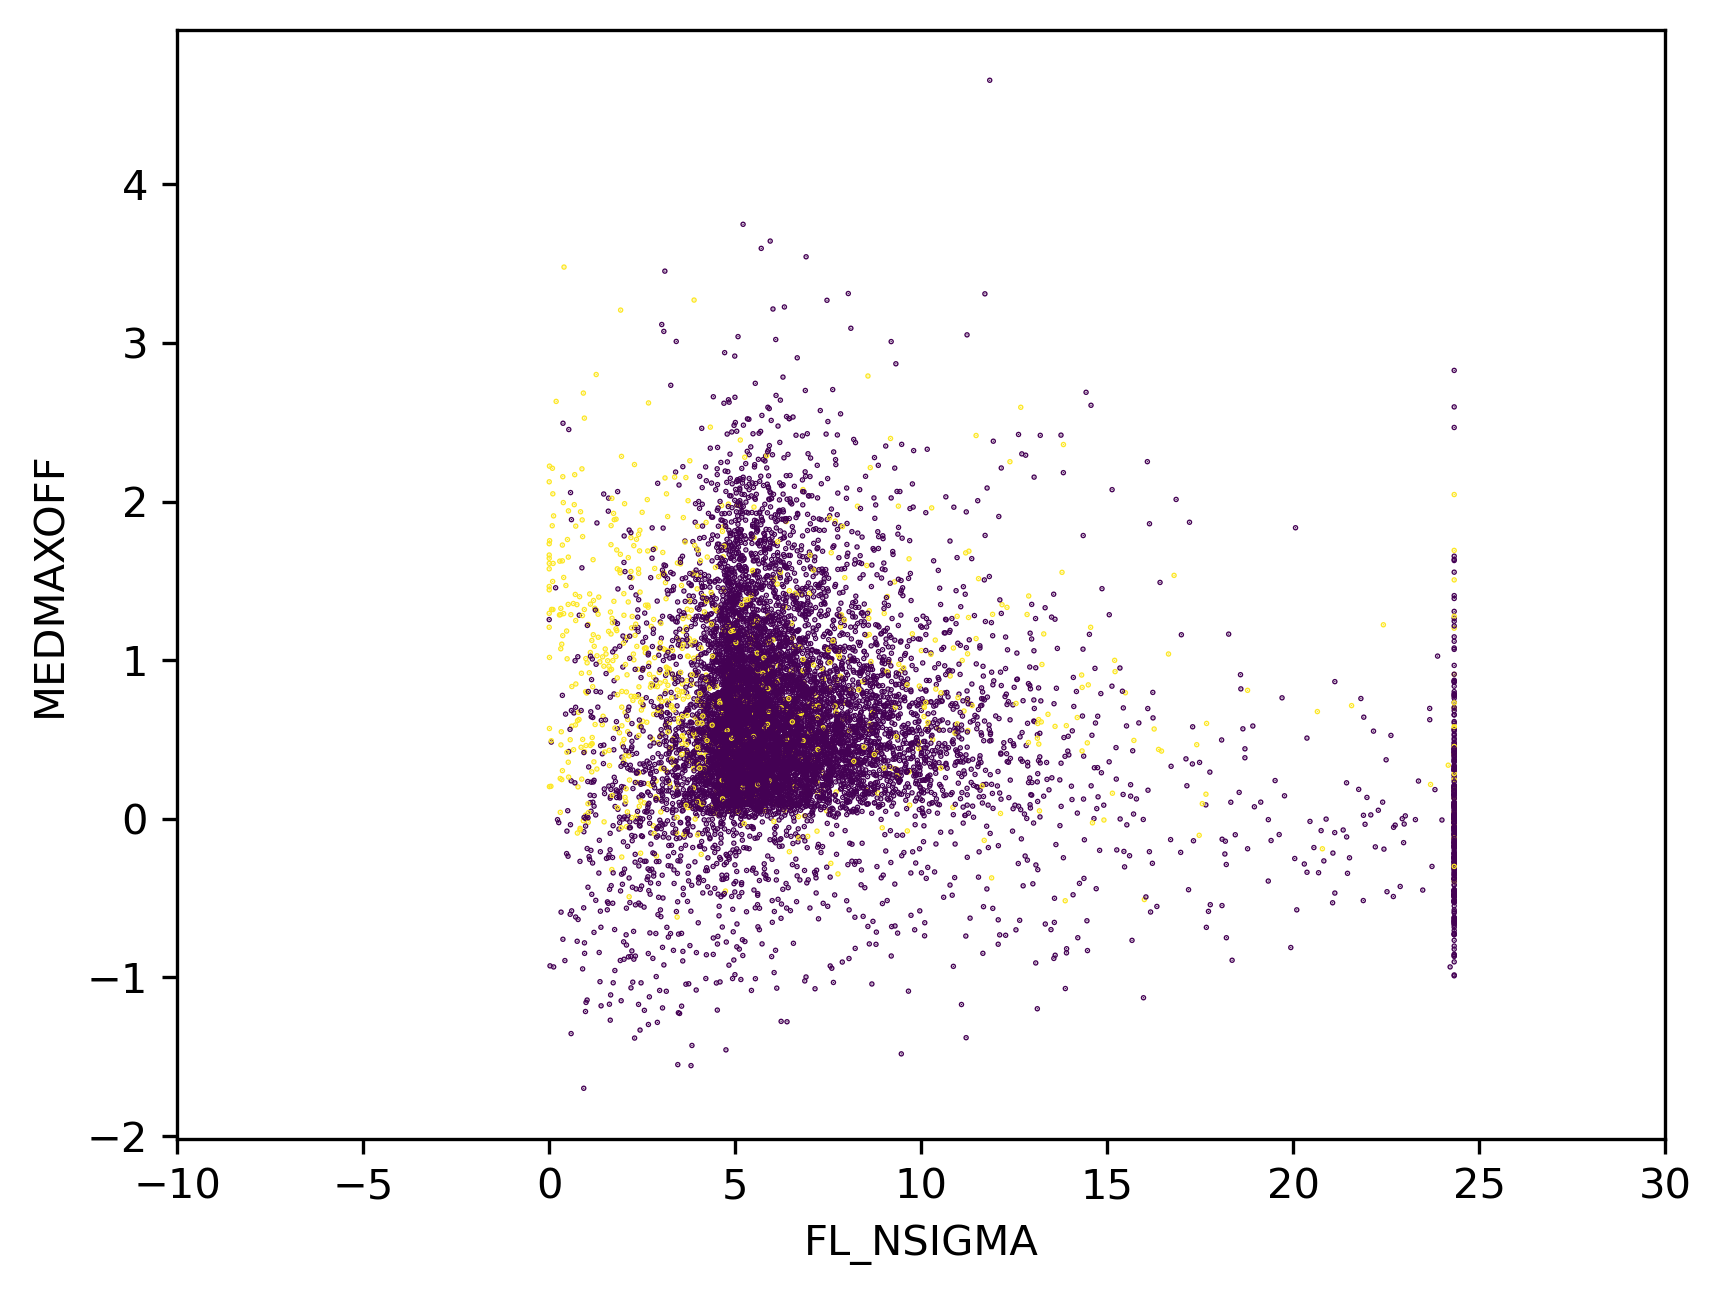

In [60]:
plt.scatter(X_train['FL_NSIGMA'], np.log10(X_train['MEDMAXOFF']), c=y_train, s=0.1)
plt.xlim([-10,30])
plt.xlabel("FL_NSIGMA")
plt.ylabel('MEDMAXOFF')
plt.show()

Lets retrain FIGS on these variables only

In [61]:
important_variables = ["F_PROB_FLCON", "FL_DT_ERR", "FL_NSIGMA", "MEDMAXOFF"]#,"BB_MB_NCELLS","FL_RT","QU_NSIGMA","FL_TMAX","FL_TMAX_ERR","F_PROB_DIPCON"]
X_train_important = X_train[important_variables]
X_test_important = X_test[important_variables]


model_FIGS_CV = FIGSClassifierCV(n_rules_list = [2,3,4,5,6,7,8,9,10,11,12], n_trees_list = [12,12,12,12,12,12,12,12,12,12,12], scoring='f1')  # initialize a model
model_FIGS_CV.fit(X_train_important, y_train)   
preds_FIGS_CV = model_FIGS_CV.predict(X_test_important)

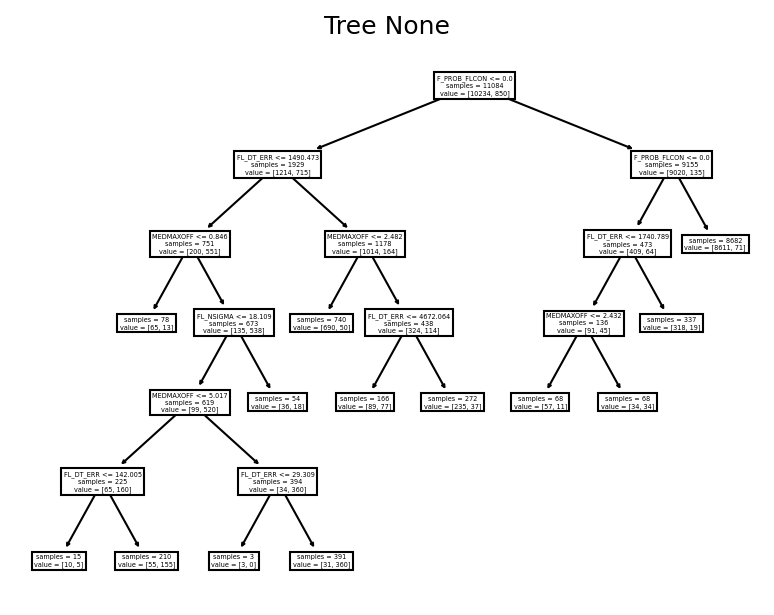

In [62]:
model_FIGS_CV.figs.plot()

In [63]:
accuracy_score(y_test, preds_FIGS_CV)

0.954168170335619

In [64]:
precision_score(y_test, preds_FIGS_CV)

0.7905405405405406

In [65]:
recall_score(y_test, preds_FIGS_CV)

0.5492957746478874

In [66]:
f1_score(y_test, preds_FIGS_CV)

0.6481994459833796

Still not very good.

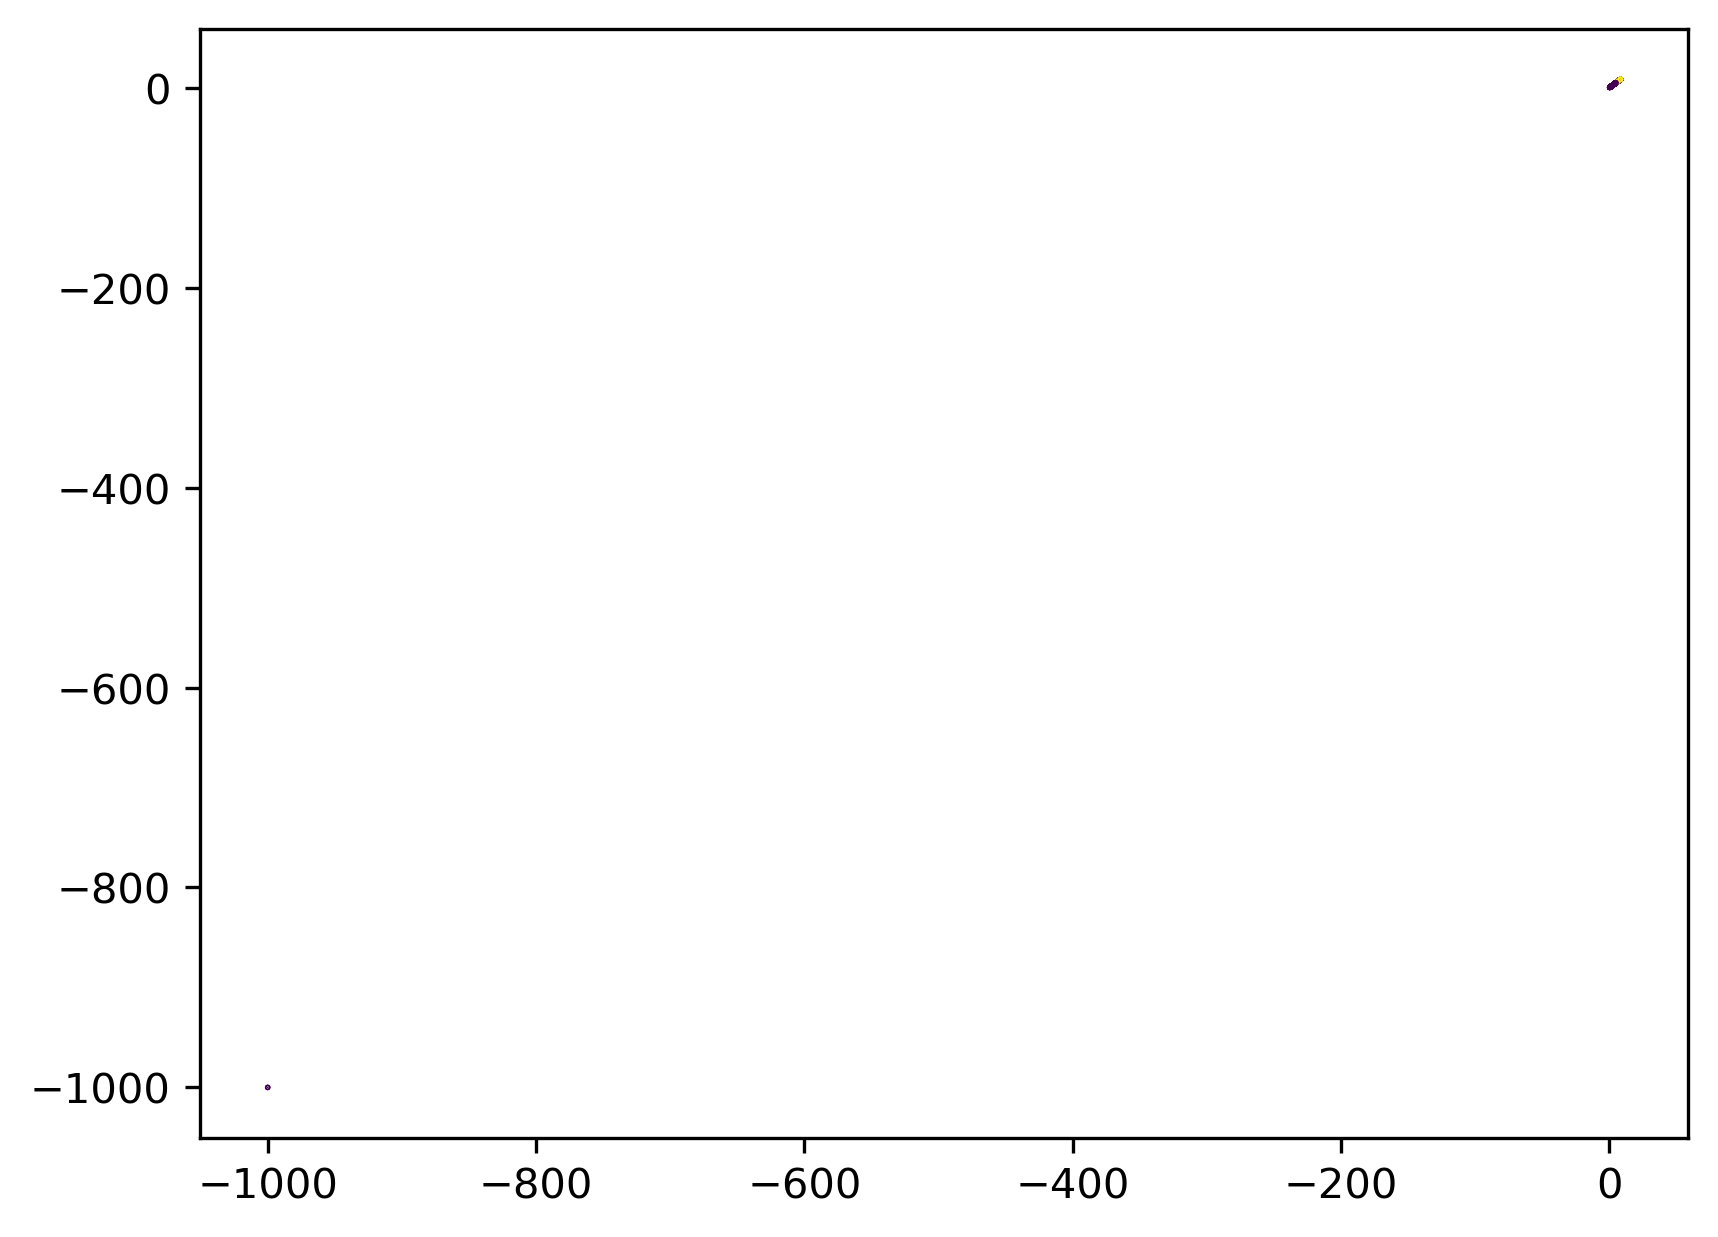

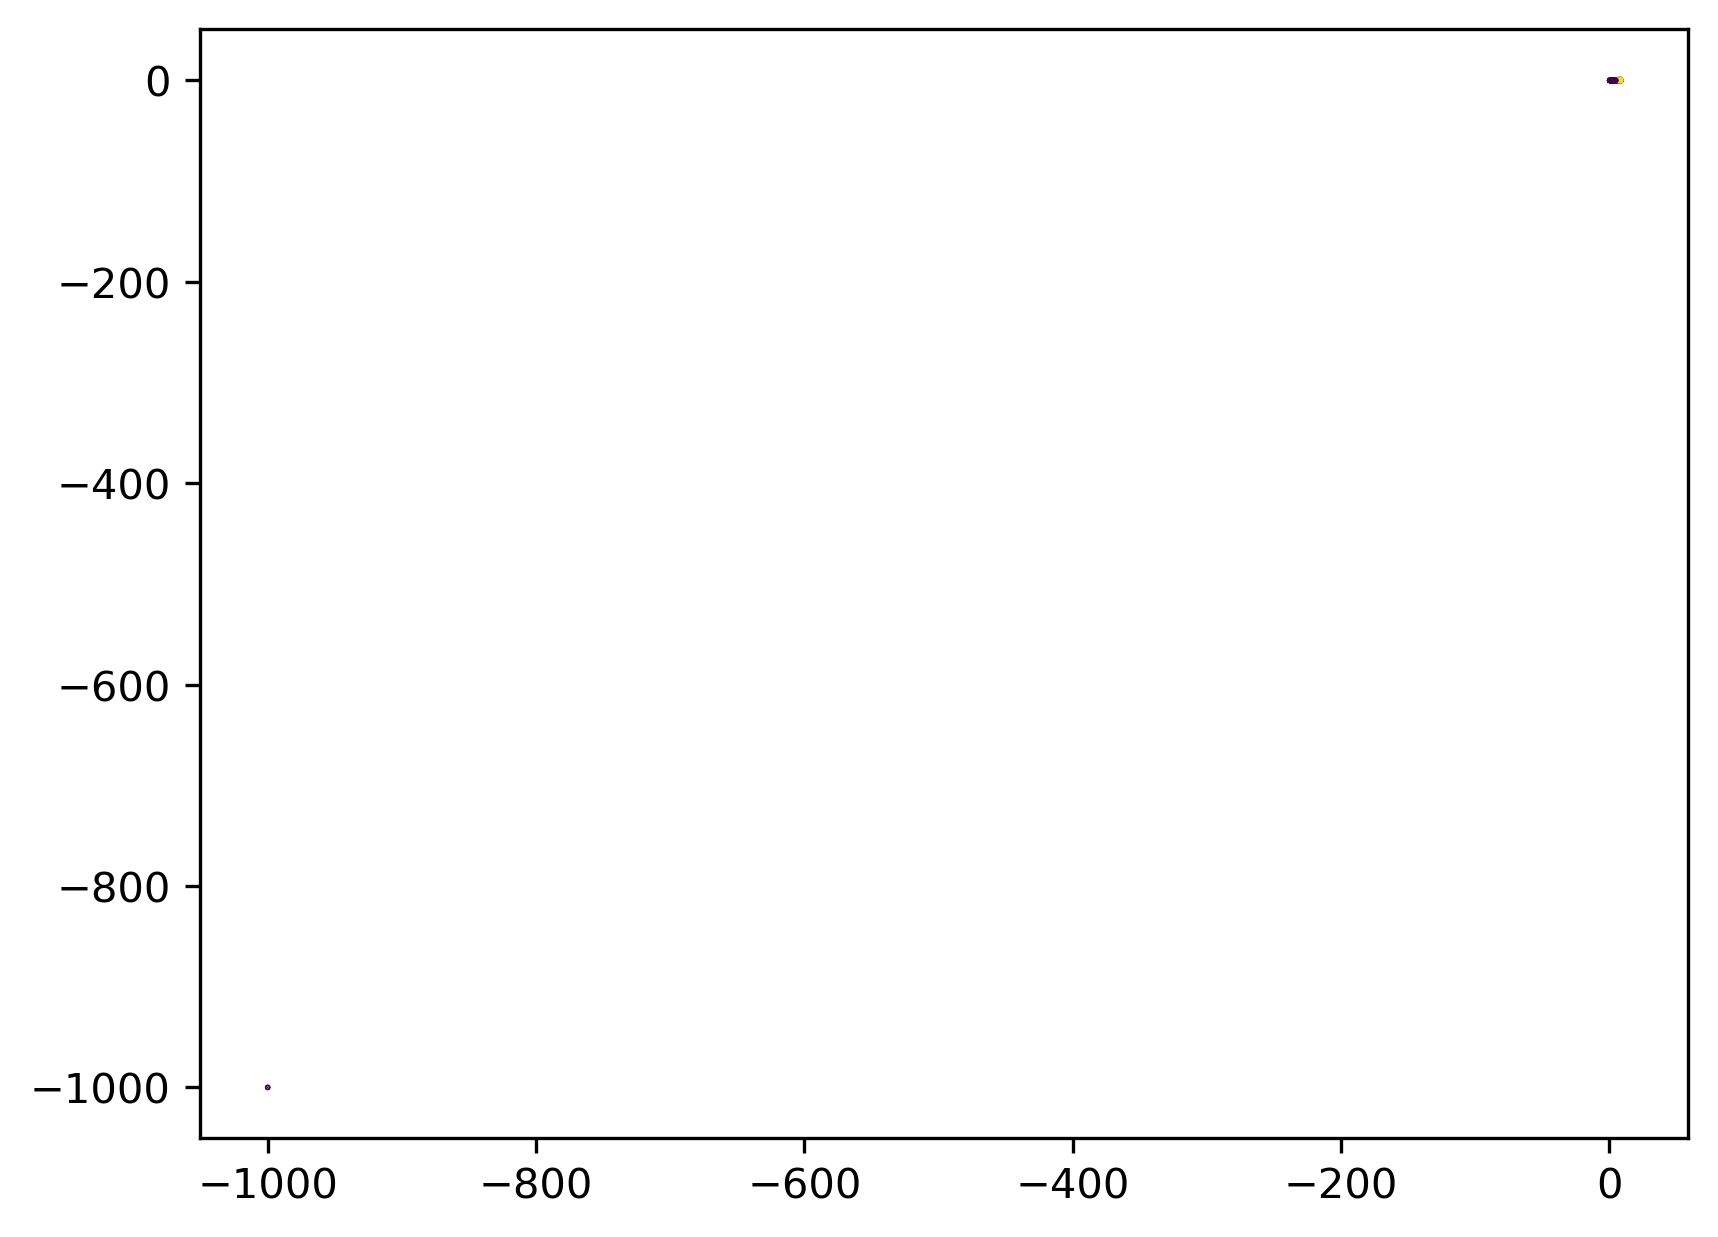

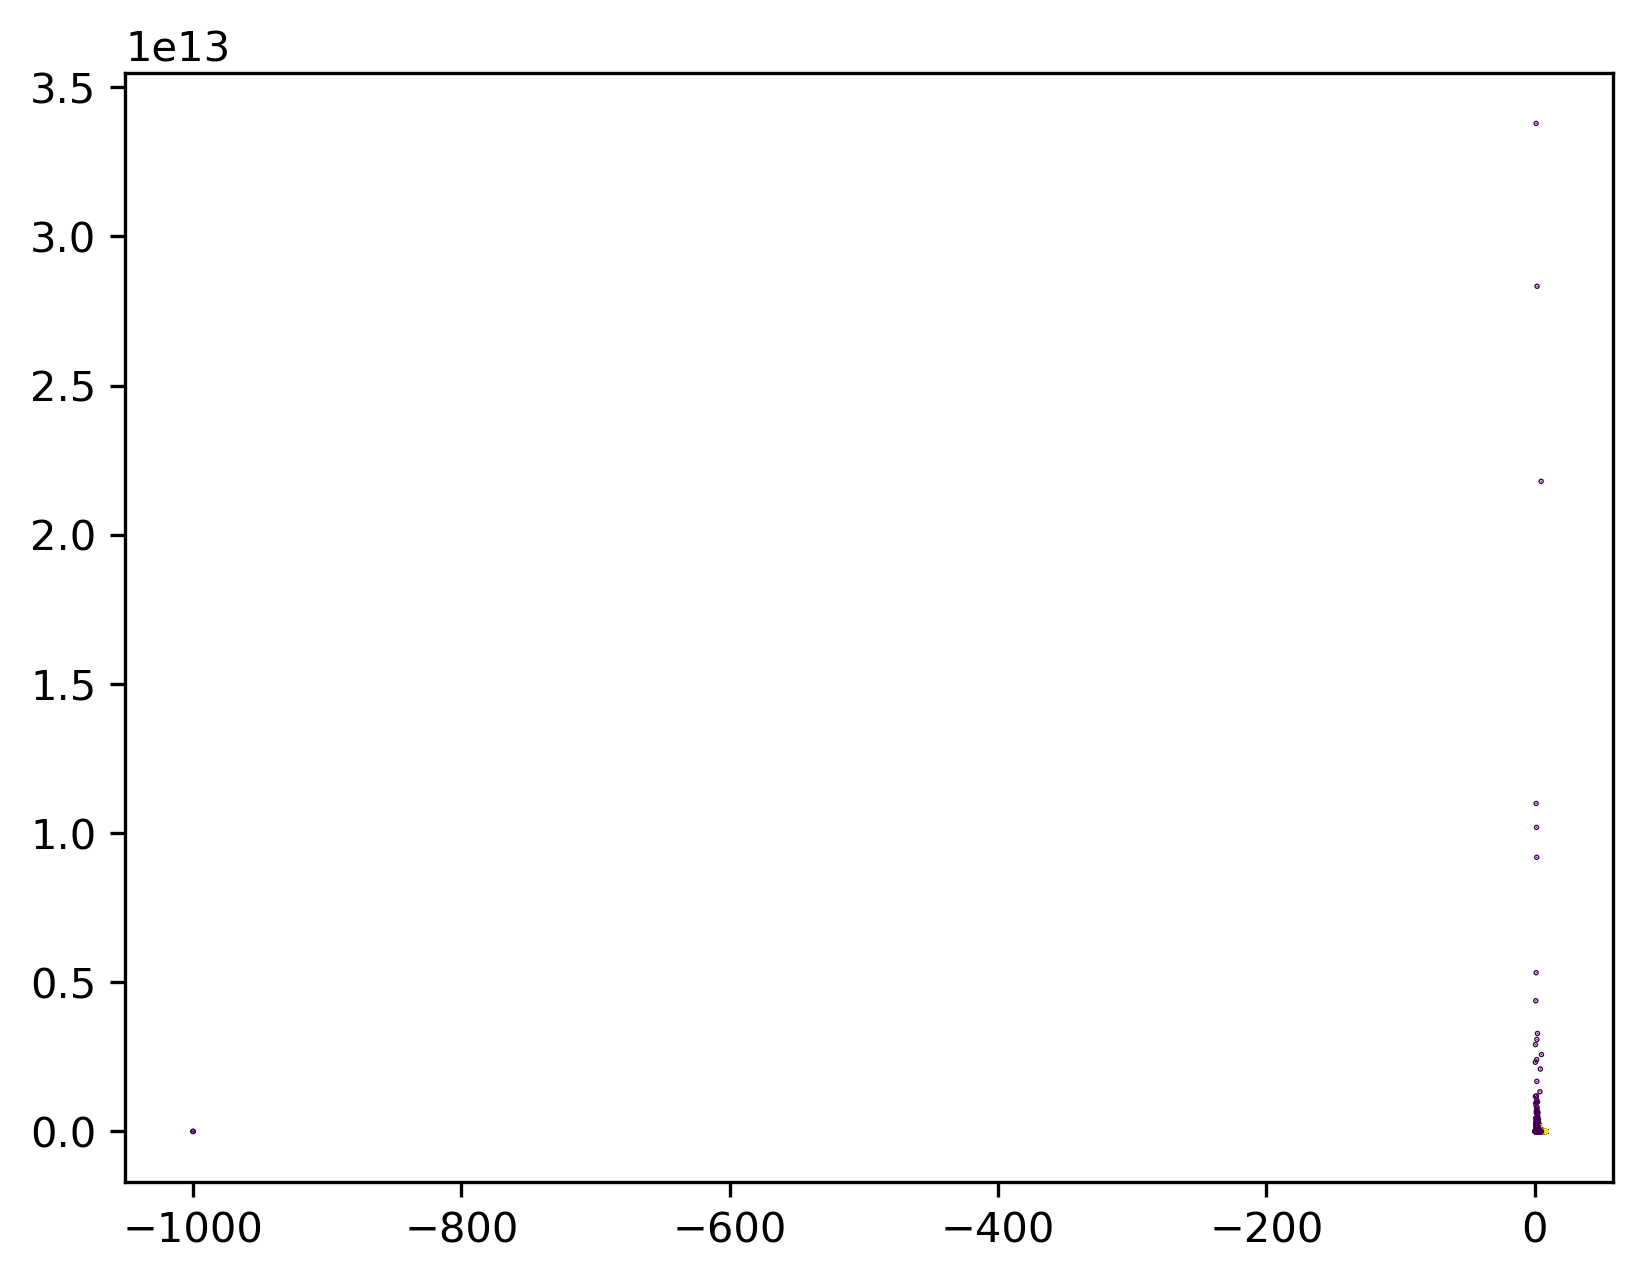

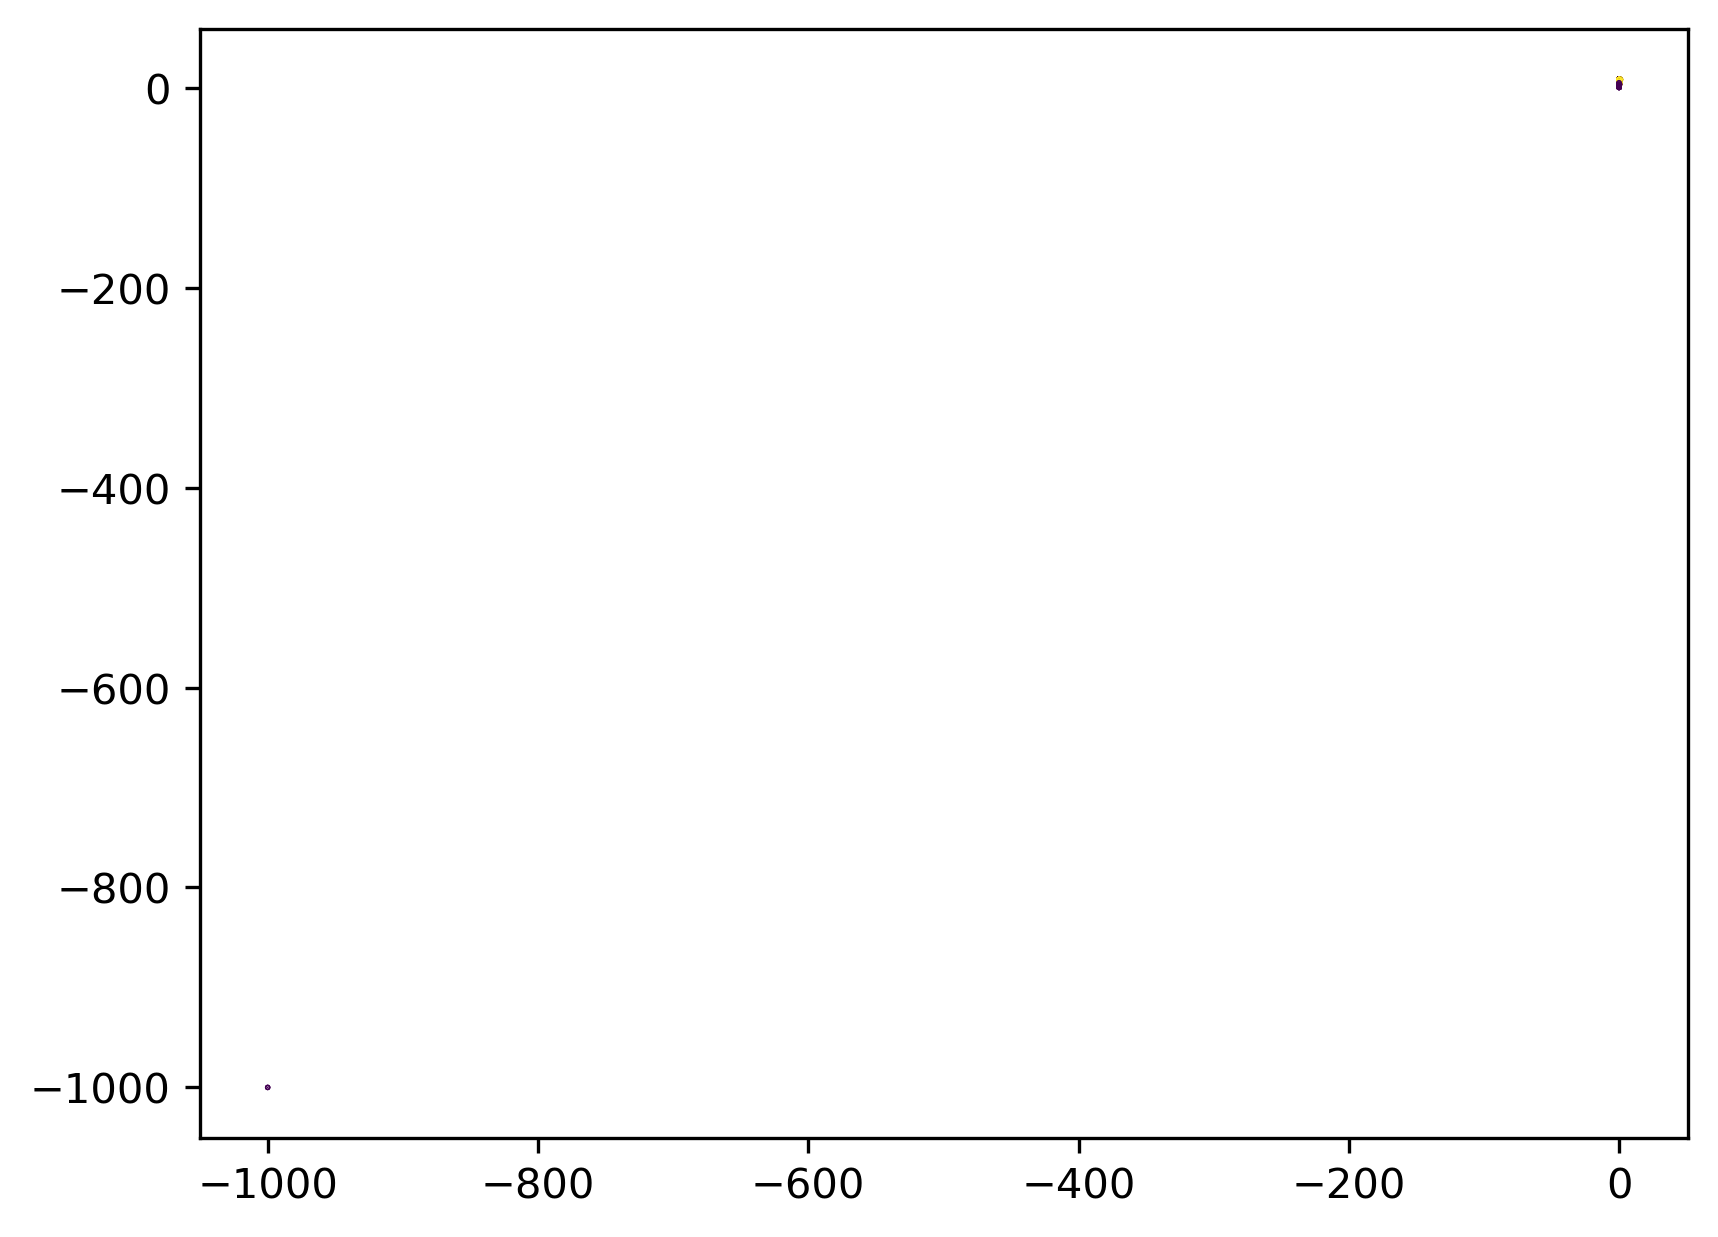

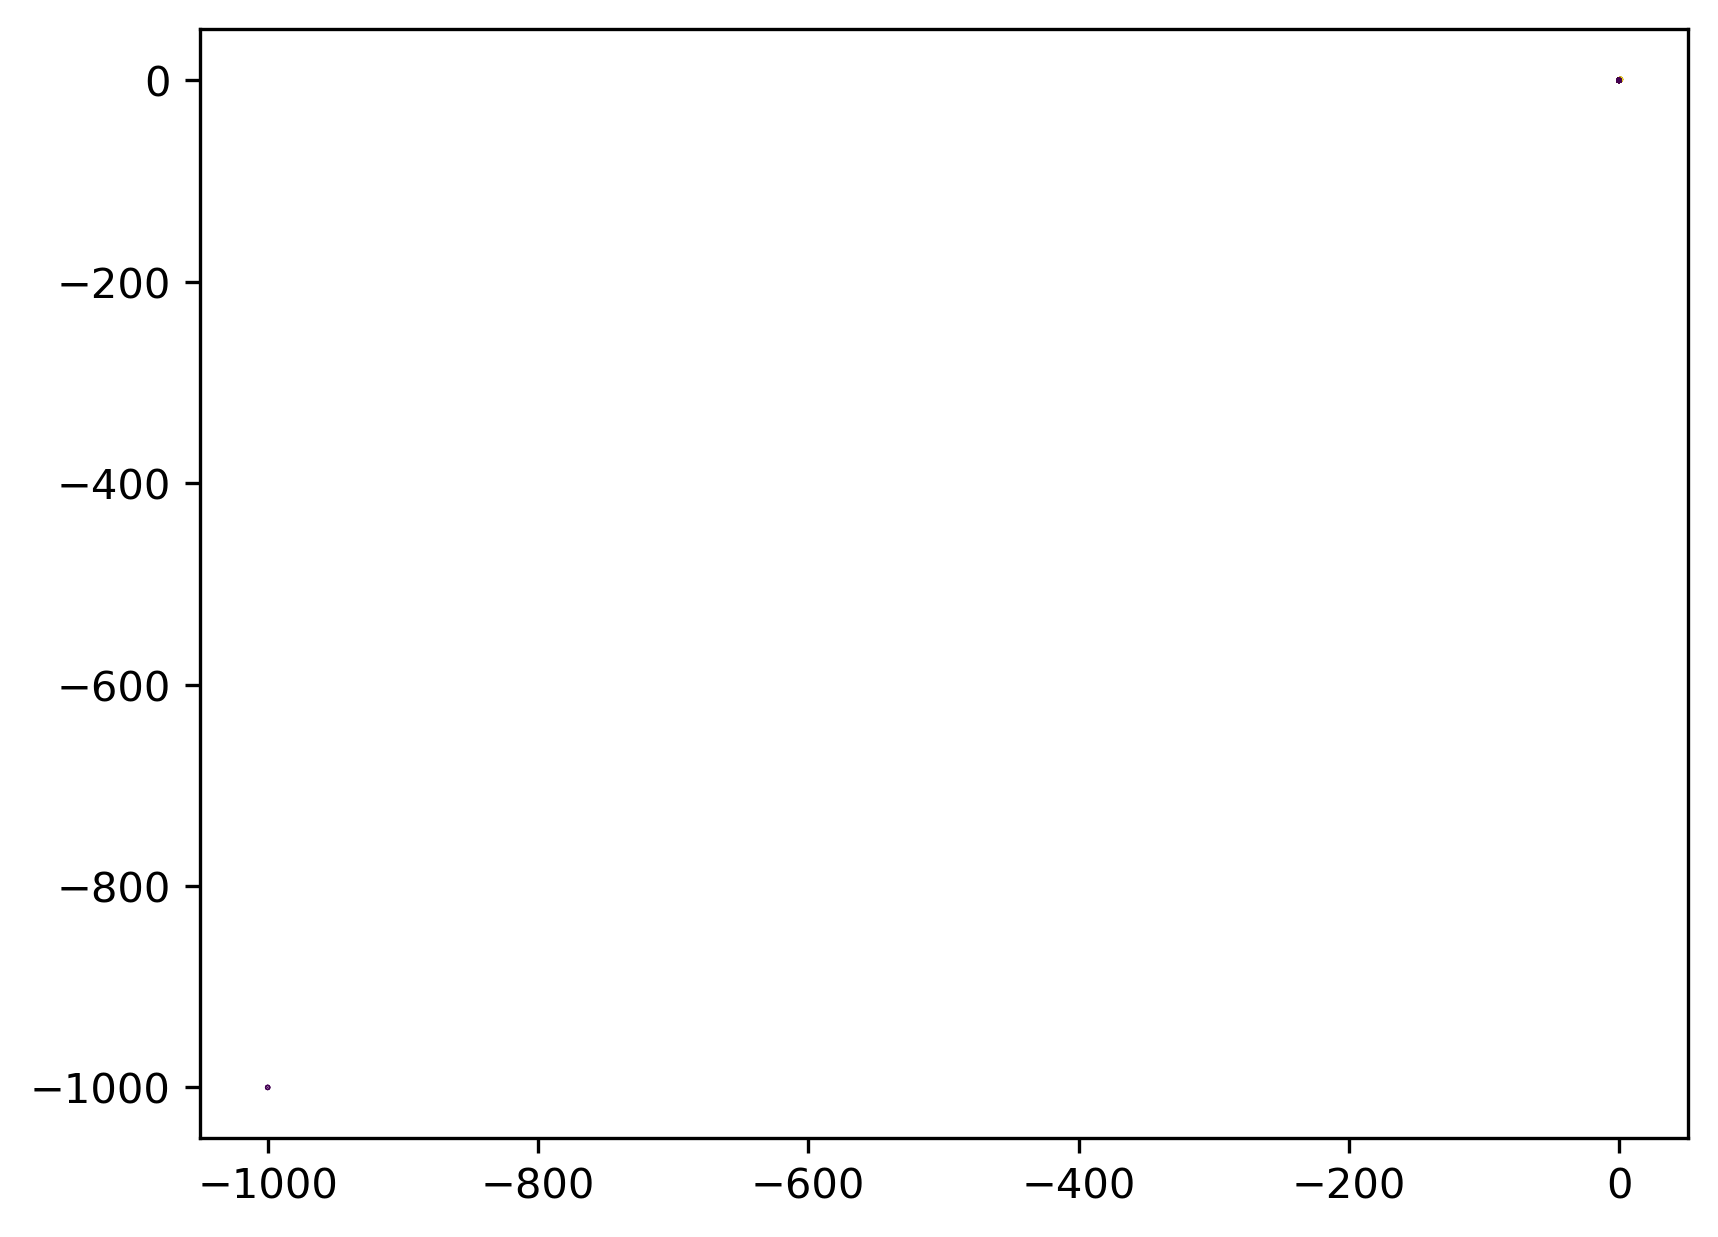

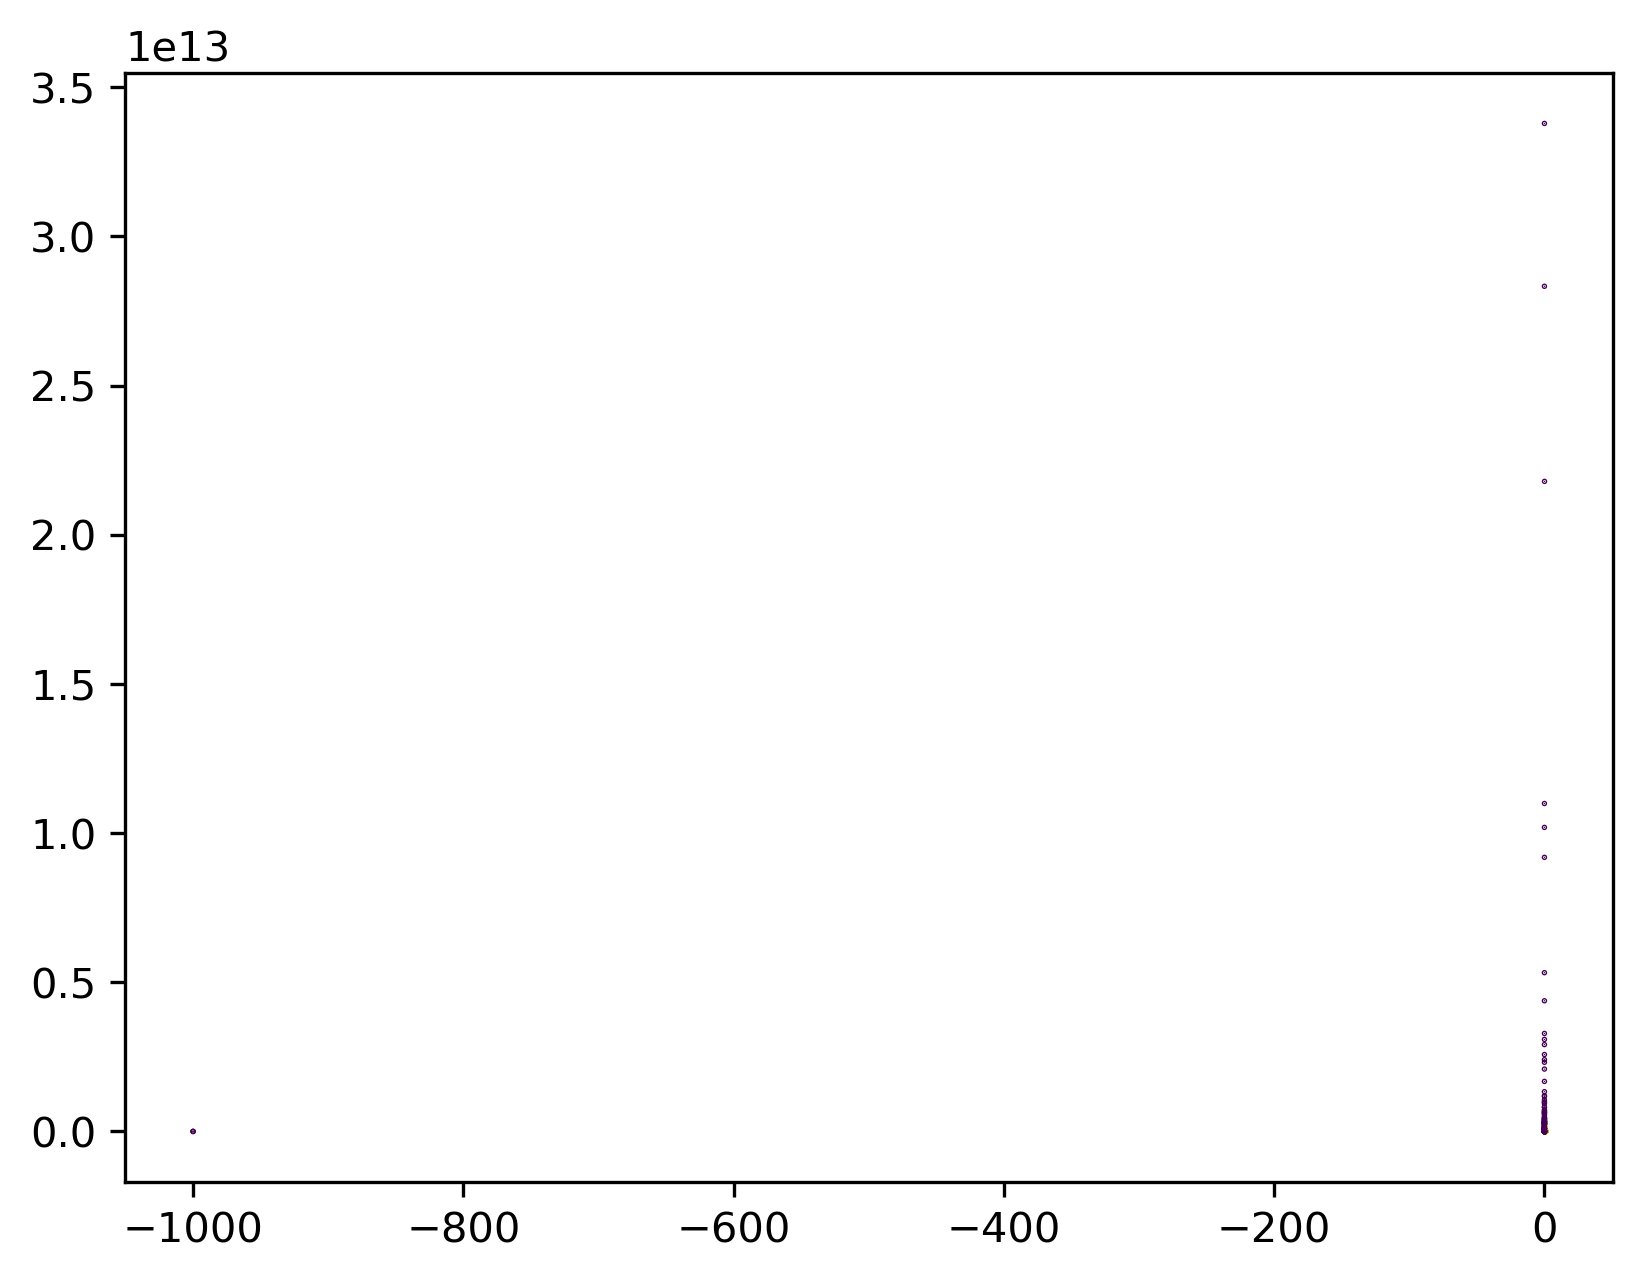

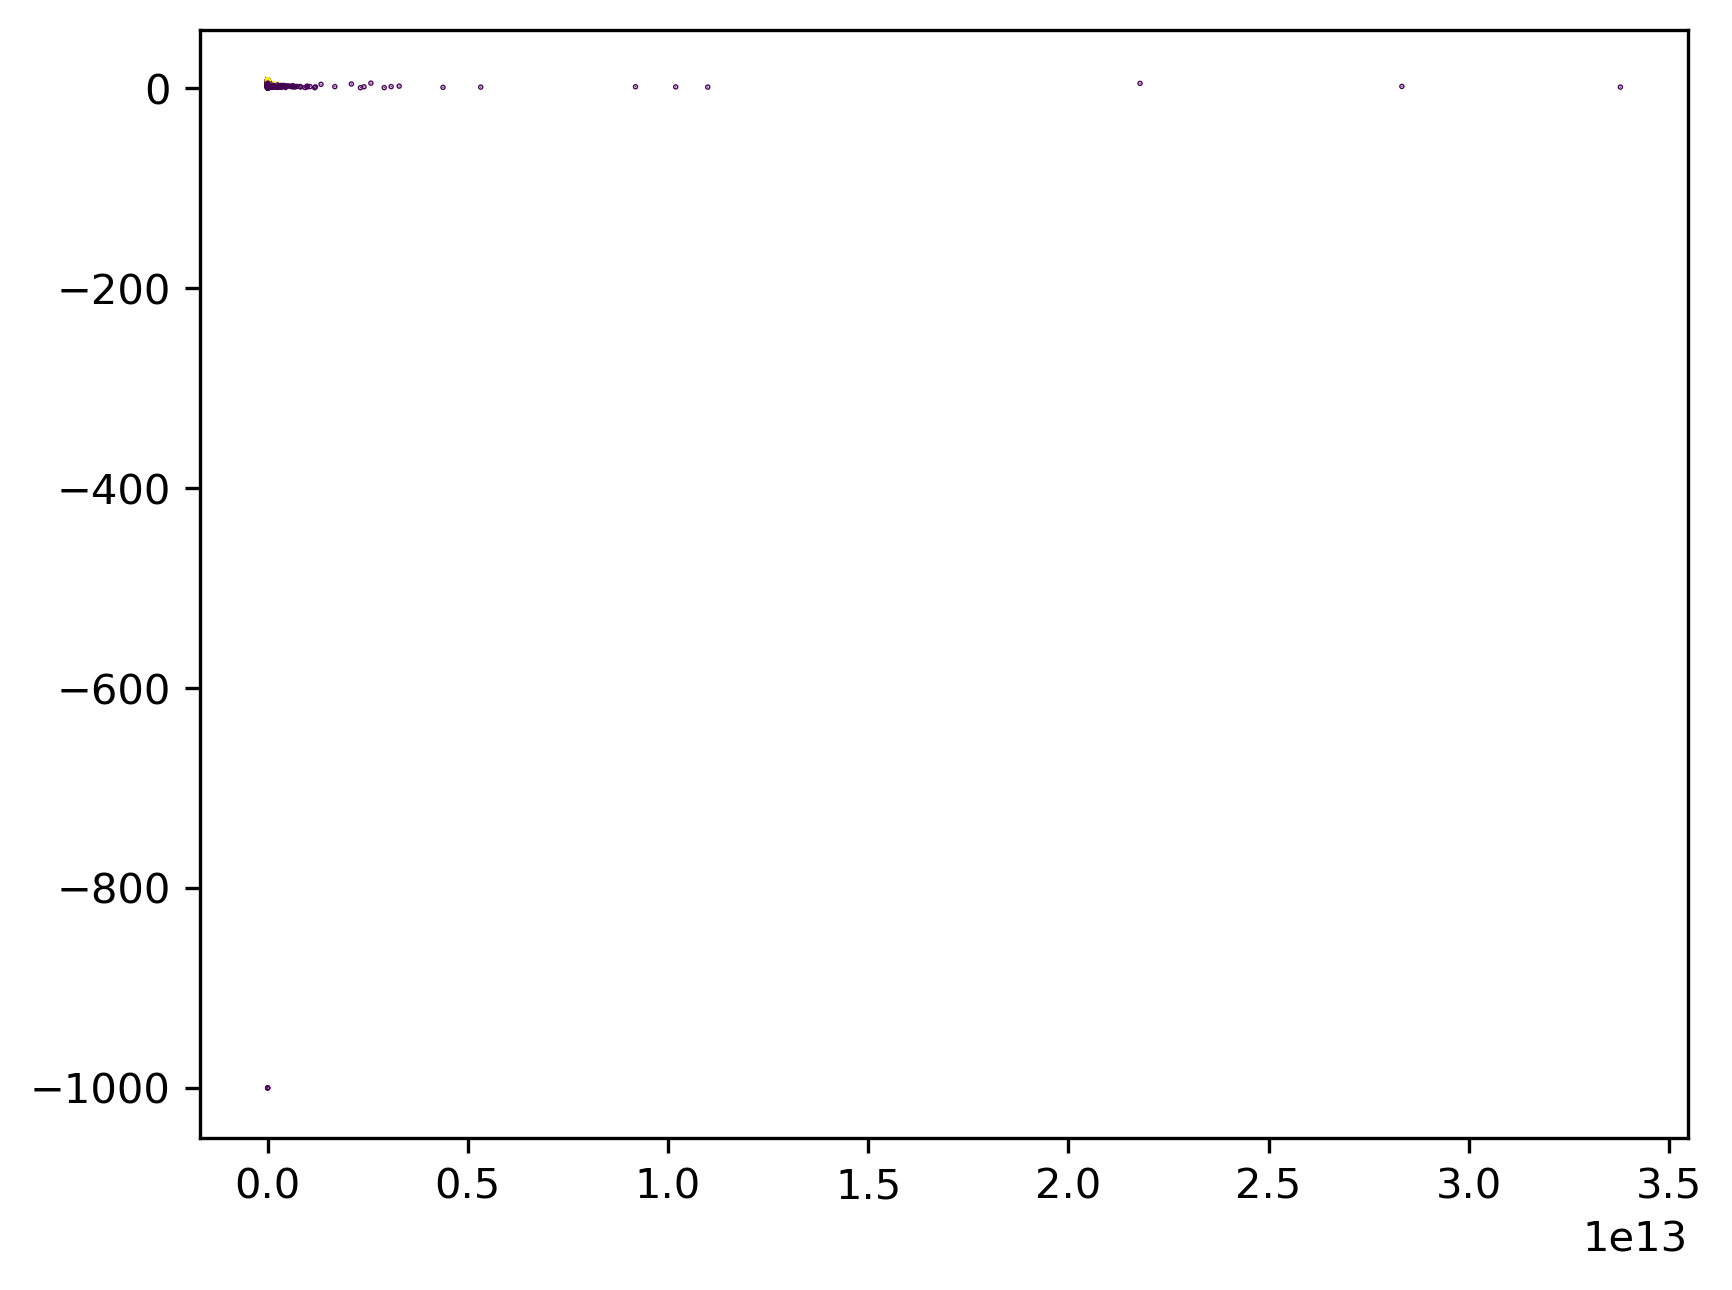

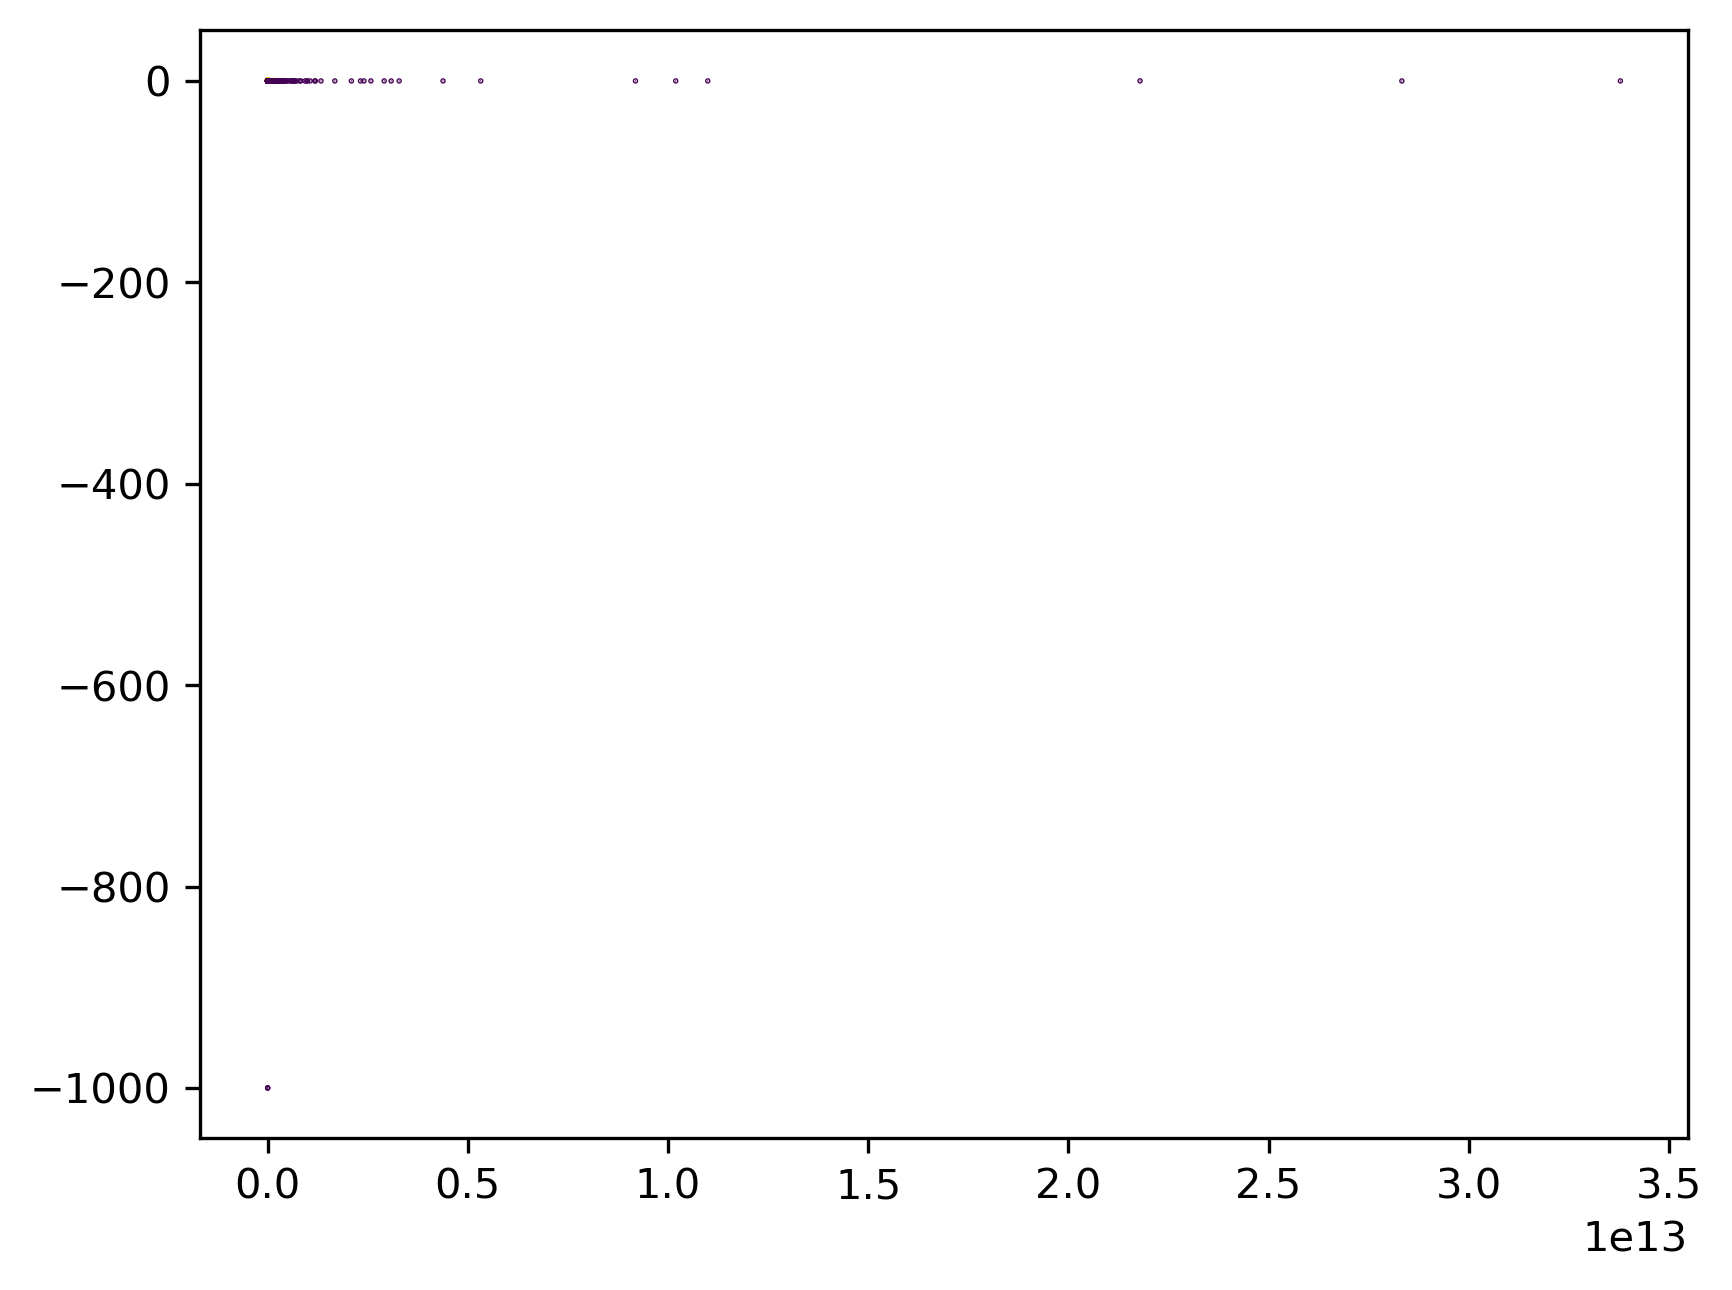

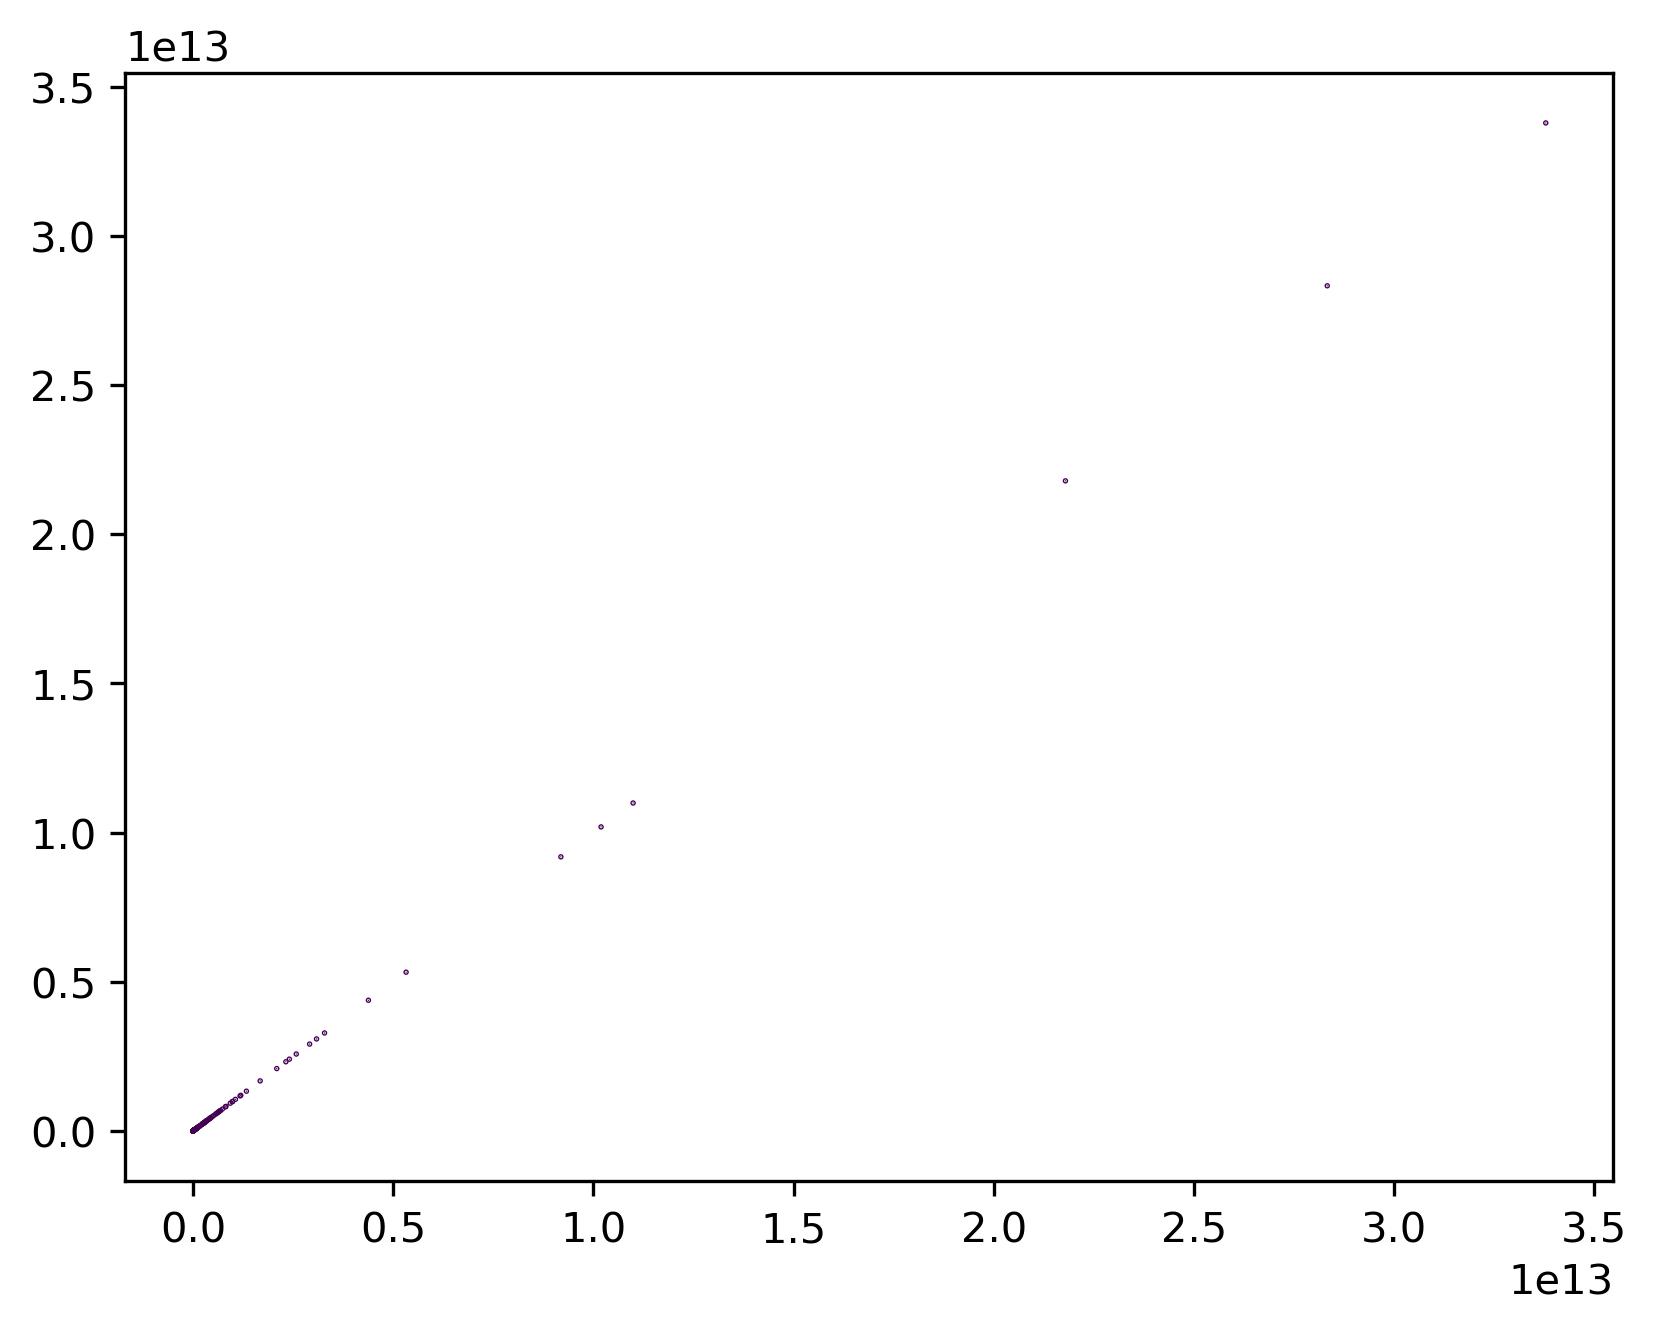

In [55]:
for v in important_variables:
    for u in important_variables:
        plt.scatter(X_train[v], X_train[u], c = y_train, s=0.1)
        plt.show()